In [87]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import sys
import tracemalloc
import seaborn as sns

In [88]:
def distance(a,b):
    return np.sqrt(np.sum((a - b)**2))                      

In [89]:
def generate_dataset(N, D):
    return np.random.rand(N, D)

def generate_query(D):
    return np.random.rand(D)

# Naive

In [90]:
def naive_knn(query, dataset, K):
    distances = [distance(query, point) for point in dataset]
    sorted_indices = np.argsort(distances)

    k_sorted_points =  np.array([dataset[i] for i in sorted_indices[:K]])
    k_sorted_distances = np.array(distances)[sorted_indices[:K]]

    return sorted_indices[:K], k_sorted_points,  k_sorted_distances

In [91]:
N,D,K= 1000, 5, 10
ds= generate_dataset(N,D)
q= generate_query(D)
if D==2:
    plt.scatter(ds[:, 0], ds[:, 1])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Scatter plot of 2D Dataset')
    plt.show()

In [92]:
indices, points, distances=naive_knn(q, ds, K)
print(points.shape)
print(indices)
print(points)
print(distances)

(10, 5)
[988 780  27 943  93 215 475 950 312 690]
[[0.34184904 0.43369433 0.84847177 0.36325535 0.79393513]
 [0.43130171 0.37904049 0.91506073 0.25116927 0.84421233]
 [0.32320293 0.51879062 0.70301896 0.3636296  0.97178208]
 [0.32085454 0.59605012 0.99573445 0.43526228 0.9206914 ]
 [0.37487058 0.28571209 0.86859913 0.22359584 0.96322254]
 [0.42777313 0.38432665 0.67964728 0.21825389 0.94996118]
 [0.27538117 0.3063135  0.78898516 0.44641952 0.79838034]
 [0.34124445 0.44418341 0.67558677 0.50889407 0.86144569]
 [0.35342138 0.23687056 0.78052552 0.27480604 0.82261432]
 [0.45476434 0.6747863  0.67753161 0.37312262 0.94169199]]
[0.10281744 0.15009927 0.2024052  0.22791333 0.24103225 0.24691894
 0.25023152 0.2534136  0.26367141 0.2861823 ]


# KD Tree

In [93]:
class KDTree:
    def __init__(self, data, leaf_size):
        self.data = np.hstack((data, np.arange(len(data)).reshape(-1, 1))) ##stacking the indices
        self.leaf_size = leaf_size
        self.tree = self.build_kdtree(self.data)
    
    def build_kdtree(self, data, depth=0):
        if len(data) <= self.leaf_size:
            return data  
        
        axis = depth % (data.shape[1] - 1)  # Alternate splitting axis, ignore index column
        sorted_data = data[data[:, axis].argsort()]
        median_index = len(sorted_data) // 2
        left = self.build_kdtree(sorted_data[:median_index], depth + 1)
        right = self.build_kdtree(sorted_data[median_index + 1:], depth + 1)
        
        return (sorted_data[median_index], left, right)
    
    def query(self, query, K):
        indices, distances = self._query(self.tree, query, K, depth=0) 
        points = self.data[indices, :-1]
        return indices, points, distances
    
    def _query(self, node, query, K, depth):
    
        if isinstance(node, np.ndarray): #leaf node is an array
            points = node[:, :-1] 
            original_indices = node[:, -1].astype(int)  
            distances = np.array([distance(query, point) for point in points])
            sorted_indices = np.argsort(distances)
            nearest_indices = original_indices[sorted_indices[:K]]
            nearest_distances = distances[sorted_indices[:K]]
            return nearest_indices, nearest_distances
        
        if isinstance(node, tuple) and len(node) == 3: # non-leaf node is a tuple (median point, left subtree, right subtree)
            median, left, right = node
            axis = depth % (query.shape[0])
            
            if query[axis] < median[axis]:
                primary, other = left, right
            else:
                primary, other = right, left
            
            # Recursively search the primary side
            indices, distances = self._query(primary, query, K, depth + 1)
            
            
            if len(indices) < K or abs(query[axis] - median[axis]) < max(distances): # if the other tree's data also need to be combined
                other_indices, other_distances = self._query(other, query, K, depth + 1)
                combined_indices = np.concatenate([indices, other_indices])
                combined_distances = np.concatenate([distances, other_distances])
                sorted_combined = np.argsort(combined_distances)
                indices = combined_indices[sorted_combined][:K]
                distances = combined_distances[sorted_combined][:K]
            
            return indices, distances
        
       
        return np.array([]), np.array([])


In [94]:

tree = KDTree(ds, leaf_size=20) ## training


indices, points, distances = tree.query(q, K) ##testing

print("Indices of nearest neighbors:", indices)
print("Nearest points:", points)
print("Distances to nearest points:", distances)


Indices of nearest neighbors: [988 780  27 943  93 215 475 312 690 936]
Nearest points: [[0.34184904 0.43369433 0.84847177 0.36325535 0.79393513]
 [0.43130171 0.37904049 0.91506073 0.25116927 0.84421233]
 [0.32320293 0.51879062 0.70301896 0.3636296  0.97178208]
 [0.32085454 0.59605012 0.99573445 0.43526228 0.9206914 ]
 [0.37487058 0.28571209 0.86859913 0.22359584 0.96322254]
 [0.42777313 0.38432665 0.67964728 0.21825389 0.94996118]
 [0.27538117 0.3063135  0.78898516 0.44641952 0.79838034]
 [0.35342138 0.23687056 0.78052552 0.27480604 0.82261432]
 [0.45476434 0.6747863  0.67753161 0.37312262 0.94169199]
 [0.27055926 0.24879179 0.94205822 0.29827245 0.7755053 ]]
Distances to nearest points: [0.10281744 0.15009927 0.2024052  0.22791333 0.24103225 0.24691894
 0.25023152 0.26367141 0.2861823  0.28961267]


## Testing

### Varying the dataset size and the number of dimensions

In [95]:
dataset_size = [10, 100, 500, 1000, 2000, 3000, 4000, 5000]
dimensions = [5, 10, 20, 50, 100]

In [96]:
#varying the data_set size and the number of dimensions

training_times_KD_tree = np.zeros((len(dataset_size), len(dimensions)))
testing_times_KD_tree = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_KD_tree = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_KD_tree_test = np.zeros((len(dataset_size), len(dimensions)))

for i, N in enumerate(dataset_size):
    for j, D in enumerate(dimensions):
        ds = generate_dataset(N, D)
        q = generate_query(D)
        
        tracemalloc.start()
        
        start_train_time = time.time()
        tree = KDTree(ds, leaf_size=20)
        end_train_time = time.time()
        training_times_KD_tree[i, j] = end_train_time - start_train_time
        
        current, peak = tracemalloc.get_traced_memory()
        memory_usage_KD_tree[i, j] = peak
         
        tracemalloc.clear_traces()
        tracemalloc.start()
        
        start_test_time = time.time()
        indices, points, distances = tree.query(q, K)
        end_test_time = time.time()
        testing_times_KD_tree[i, j] = end_test_time - start_test_time

        current, peak = tracemalloc.get_traced_memory()
        memory_usage_KD_tree_test[i, j] = peak
        tracemalloc.clear_traces()

tracemalloc.stop()

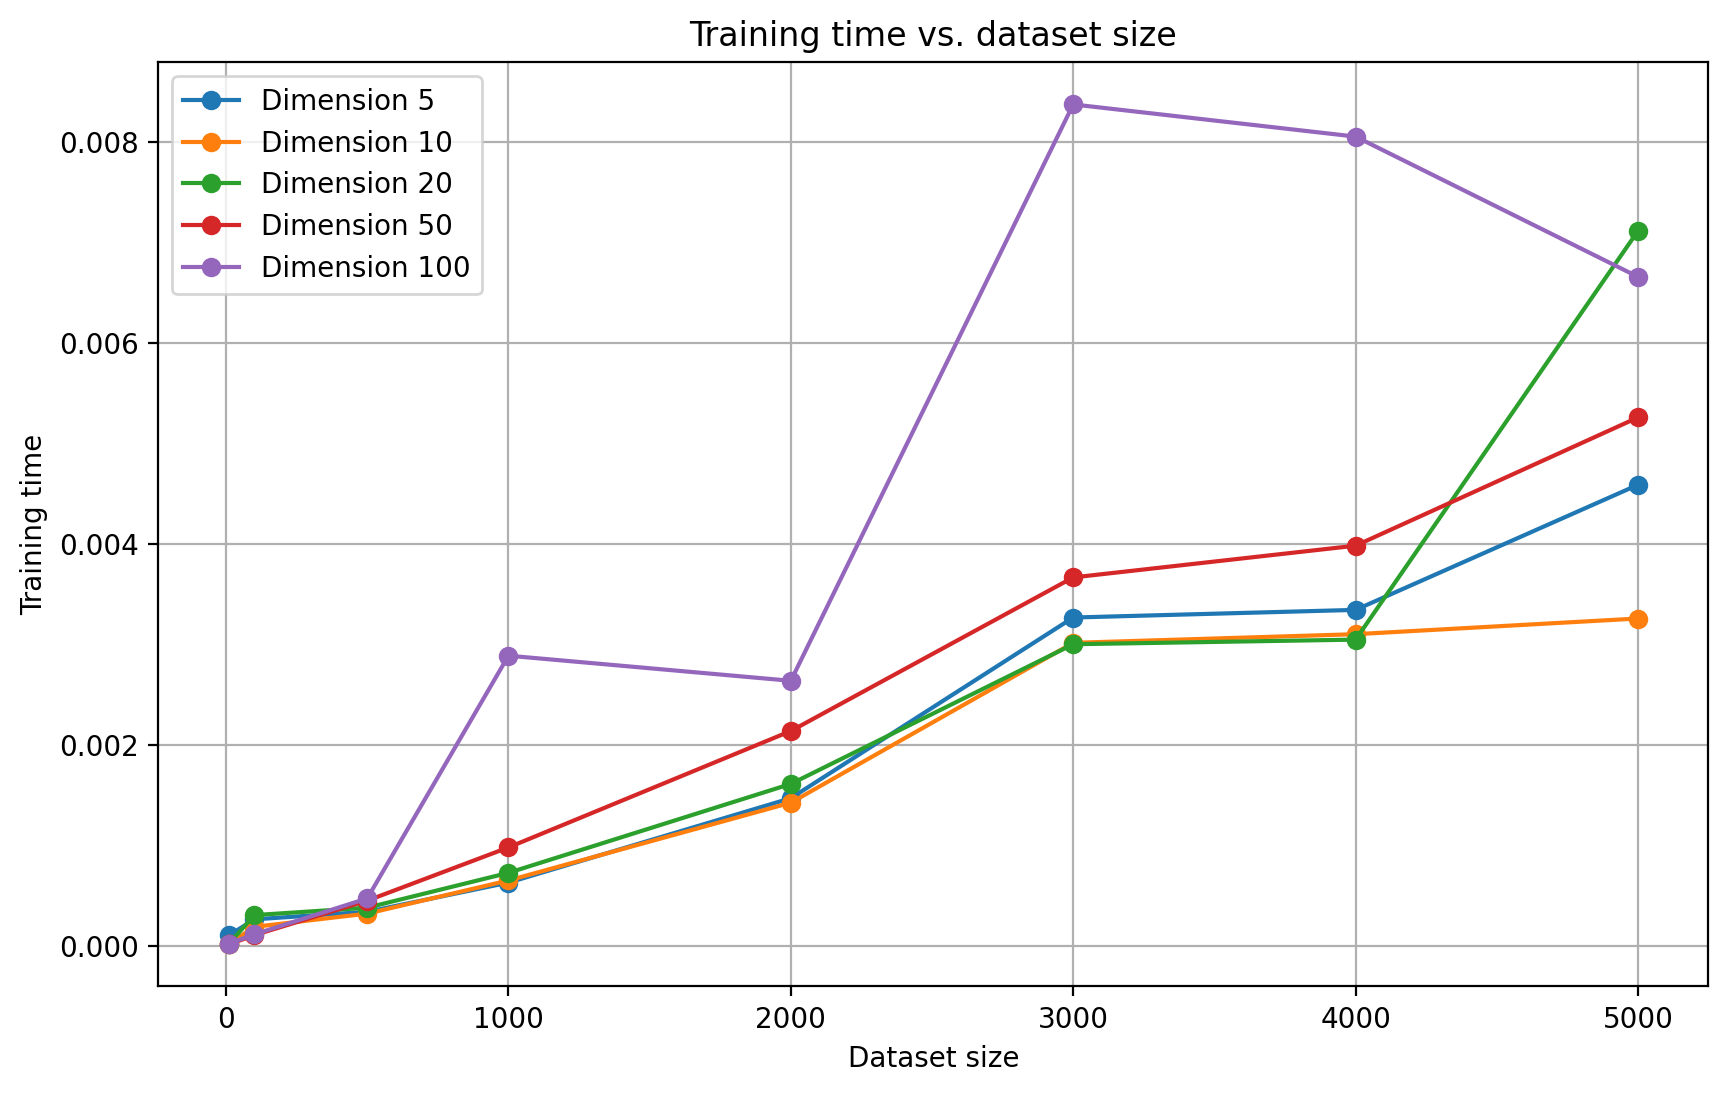

In [97]:
#plotting various figures to understand the variation

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, training_times_KD_tree[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Training time')
plt.title('Training time vs. dataset size')
plt.legend()
plt.grid(True)
plt.show()

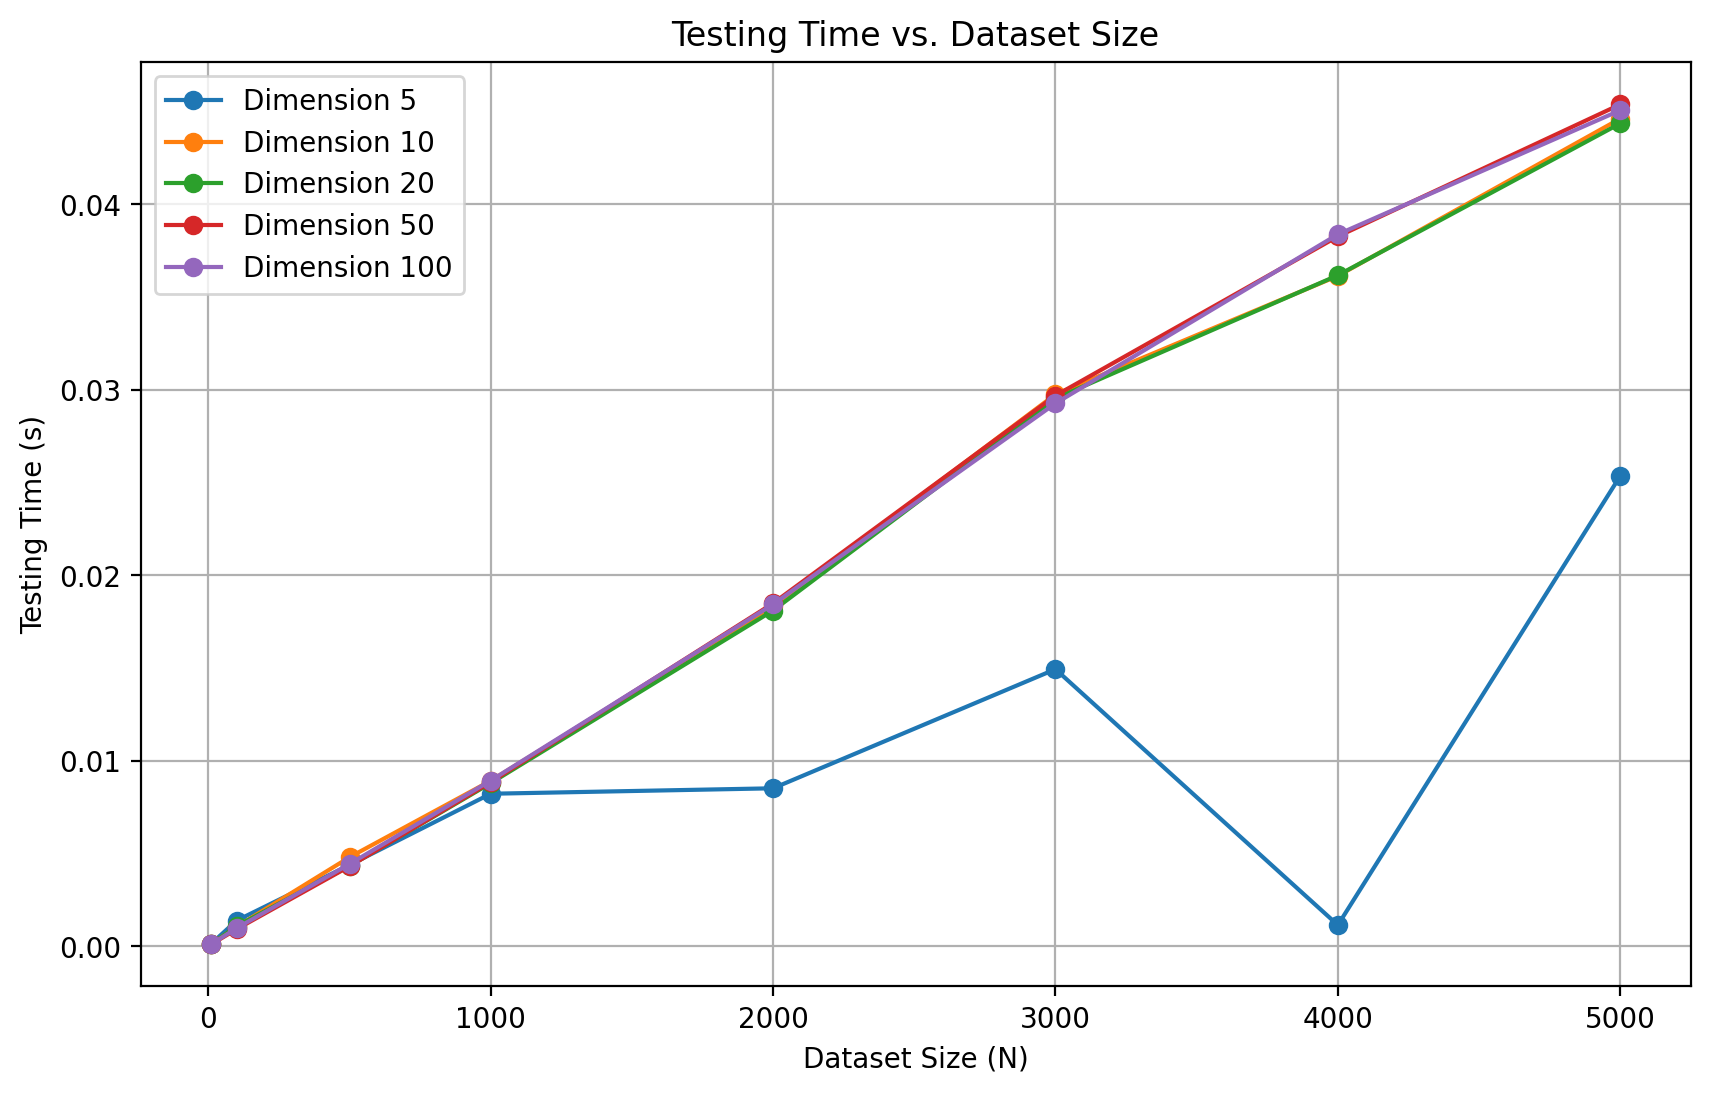

In [98]:
plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, testing_times_KD_tree[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset Size (N)')
plt.ylabel('Testing Time (s)')
plt.title('Testing Time vs. Dataset Size')
plt.legend()
plt.grid(True)
plt.show()

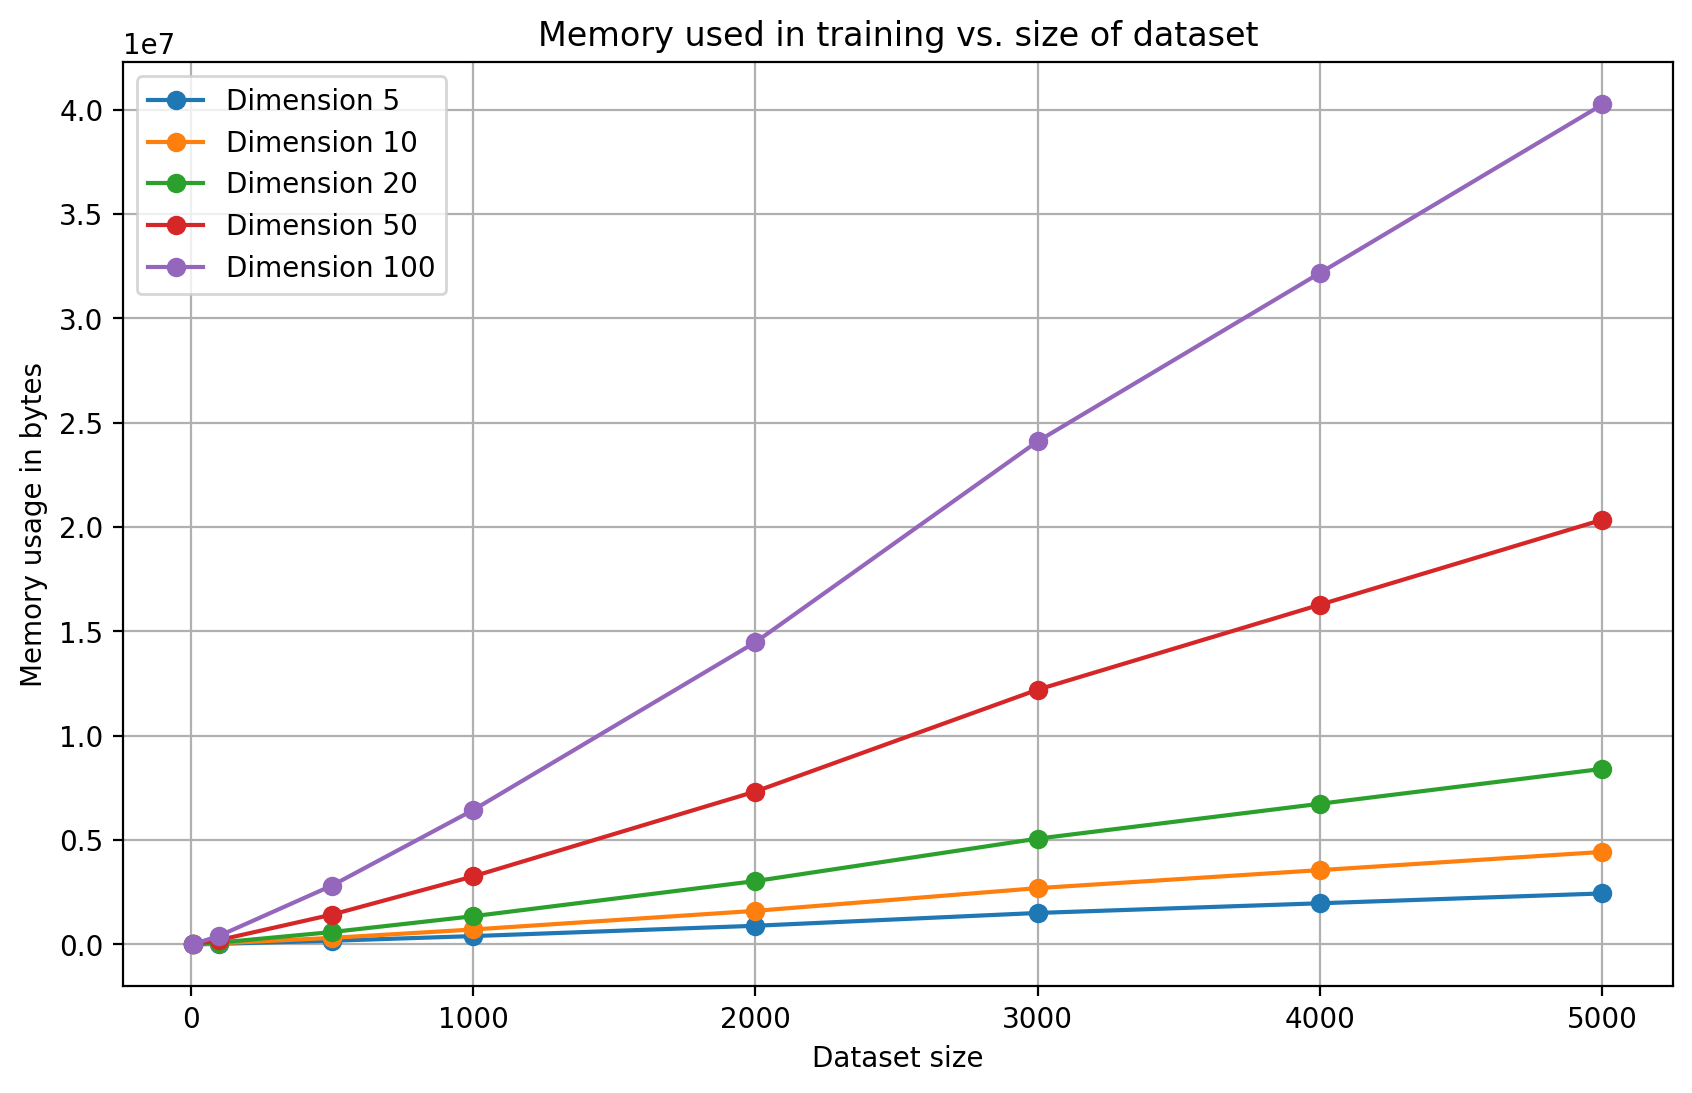

In [99]:
plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_KD_tree[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage in bytes')
plt.title('Memory used in training vs. size of dataset')
plt.legend()
plt.grid(True)
plt.show()

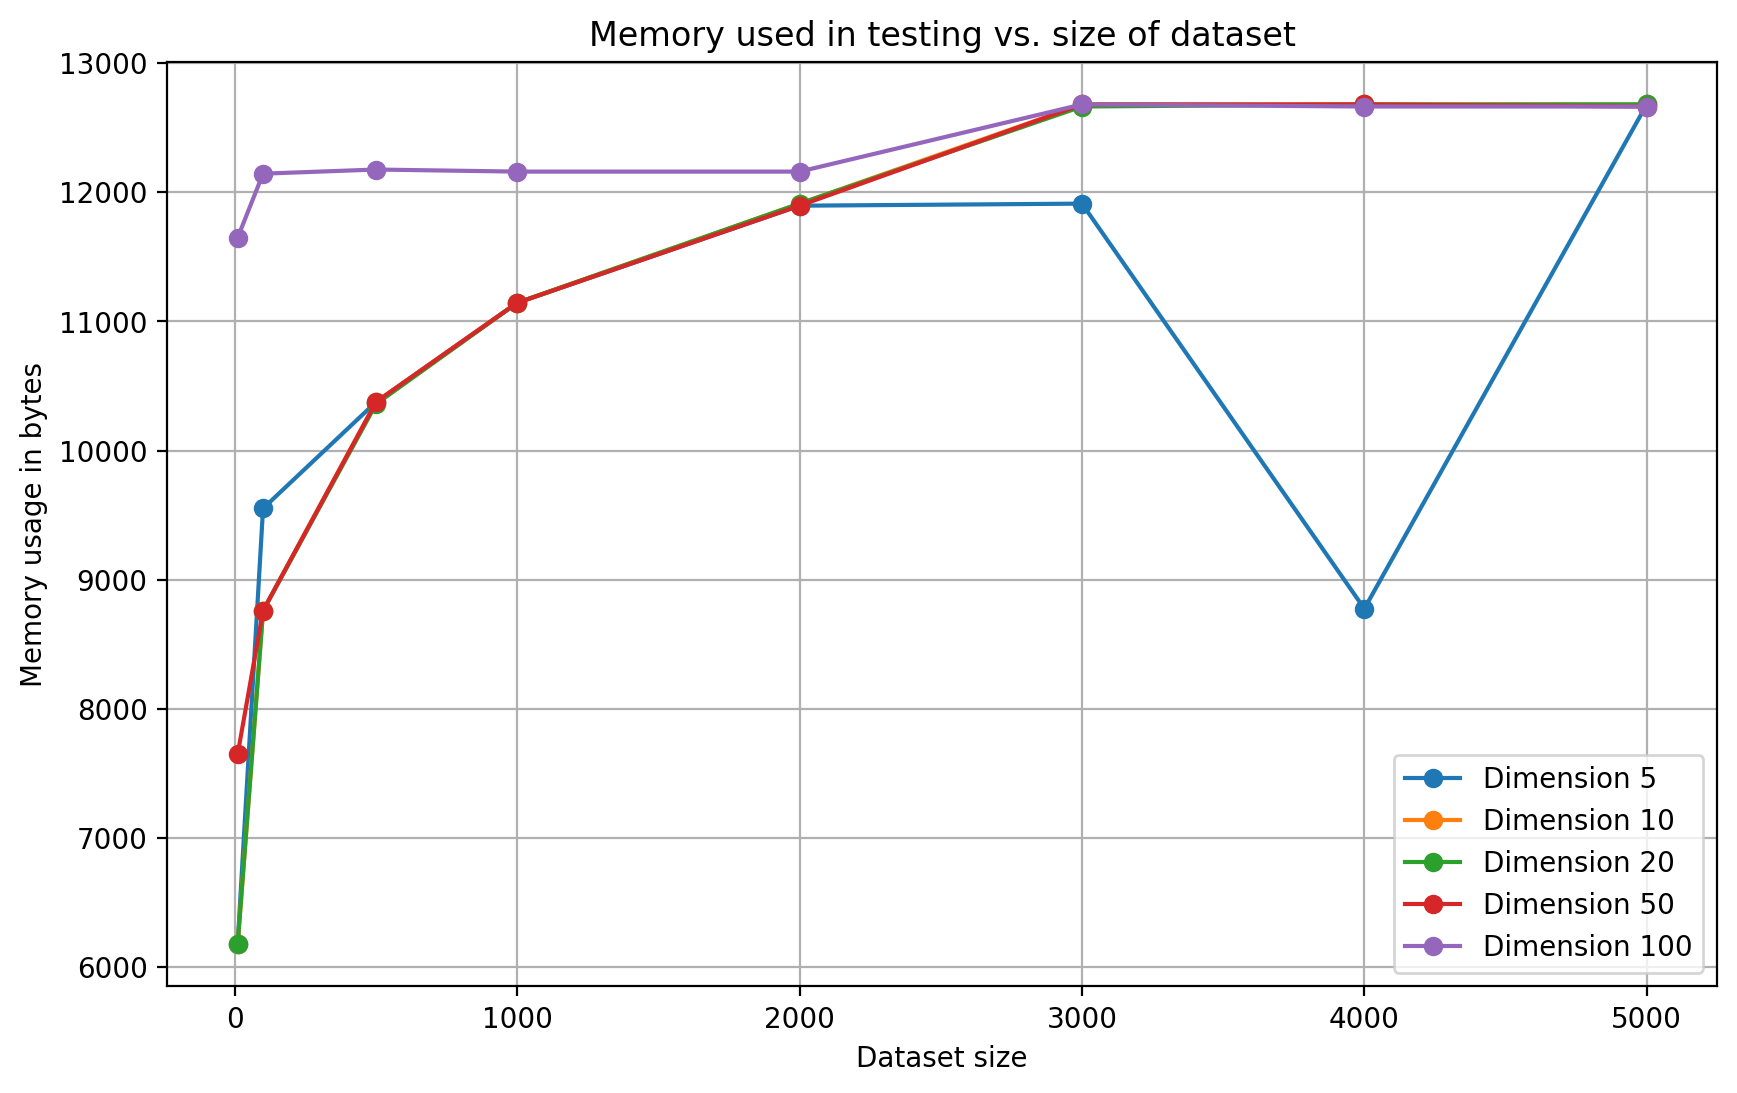

In [100]:
#Memory used in testing vs size of dataset

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_KD_tree_test[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage in bytes')
plt.title('Memory used in testing vs. size of dataset')
plt.legend()
plt.grid(True)
plt.show()


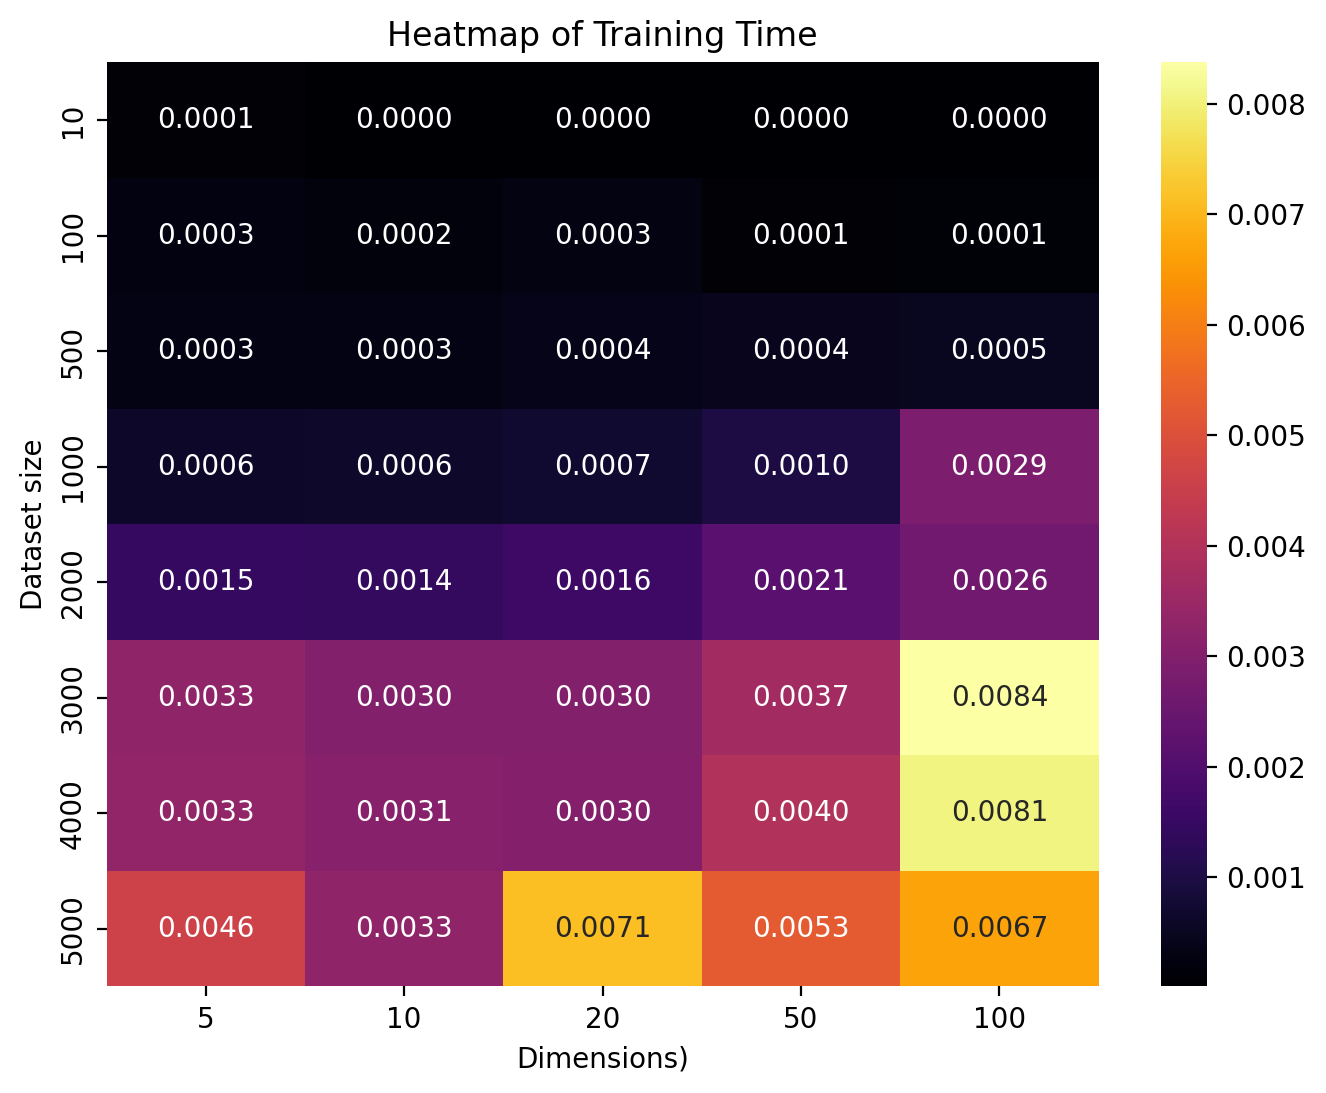

In [101]:
#plotting heatmap for visualization in 2d space
plt.figure(figsize=(8, 6))
sns.heatmap(training_times_KD_tree, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions)')
plt.ylabel('Dataset size')
plt.title('Heatmap of Training Time')
plt.show()

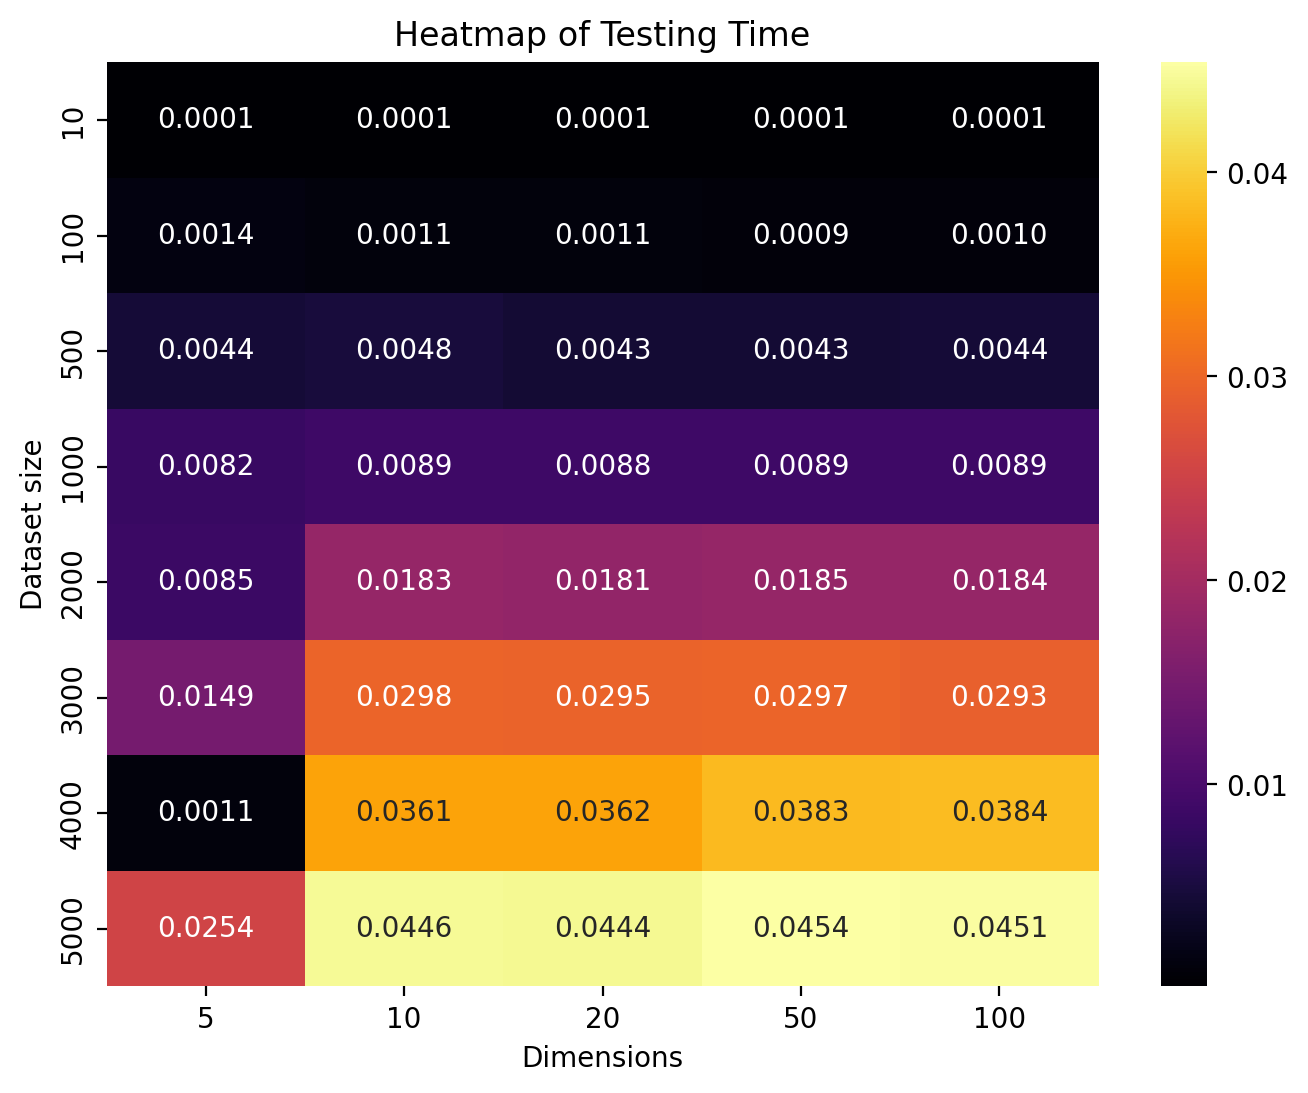

In [102]:
#heatmap of testing time

plt.figure(figsize=(8, 6))
sns.heatmap(testing_times_KD_tree, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Testing Time')
plt.show()

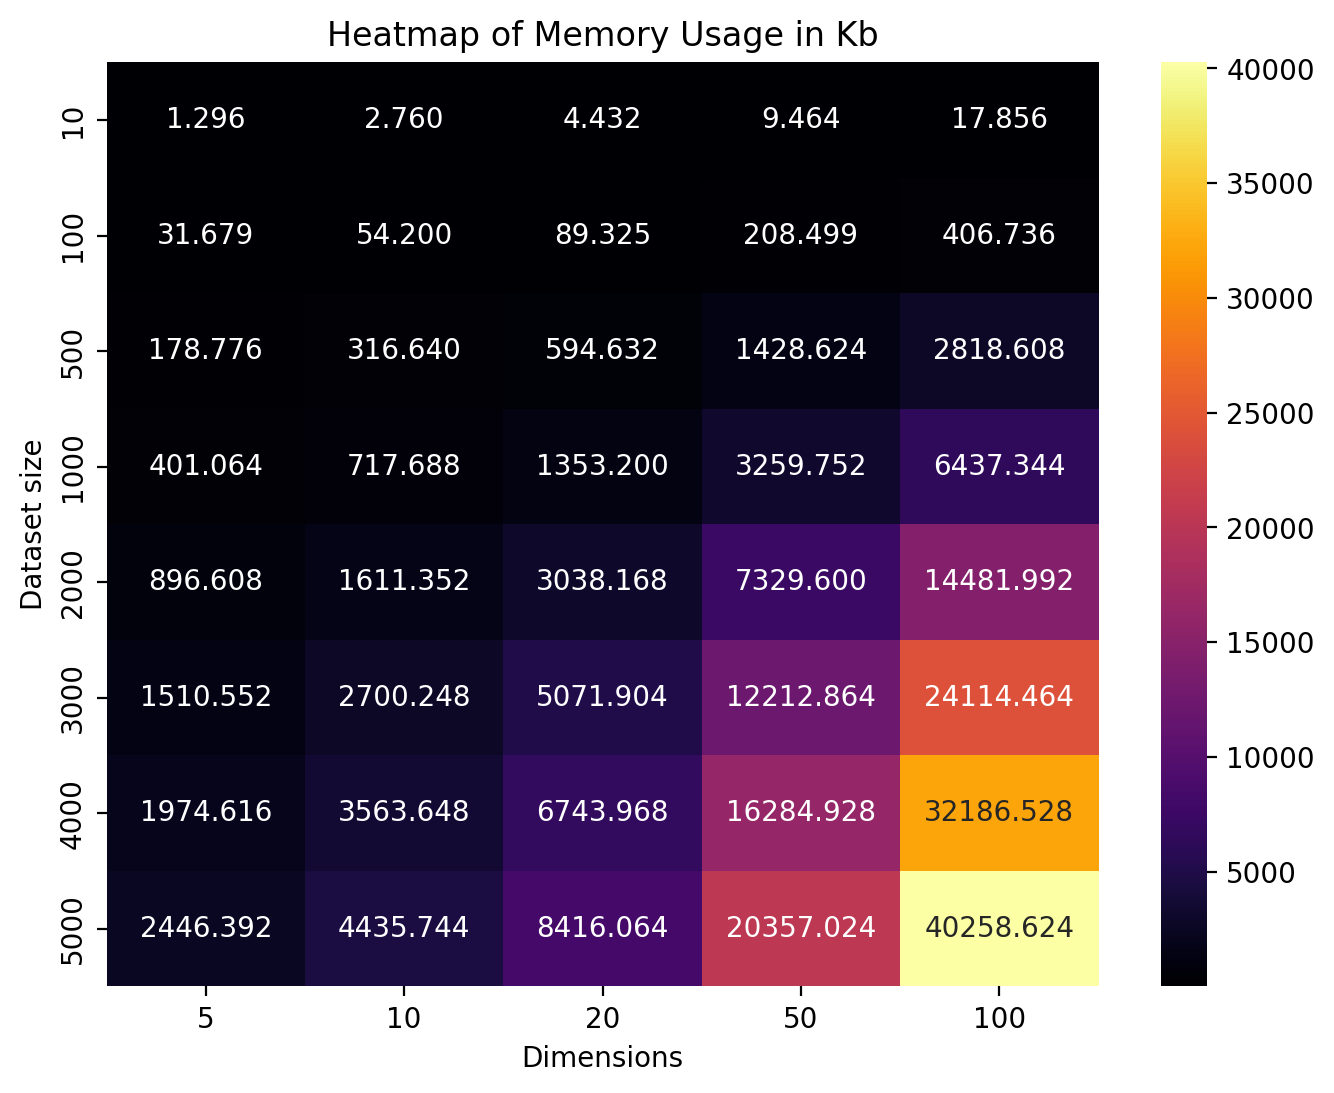

In [103]:
#heatmap of memory usage

plt.figure(figsize=(8, 6))
sns.heatmap(memory_usage_KD_tree/1000, annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Memory Usage in Kb')
plt.show()


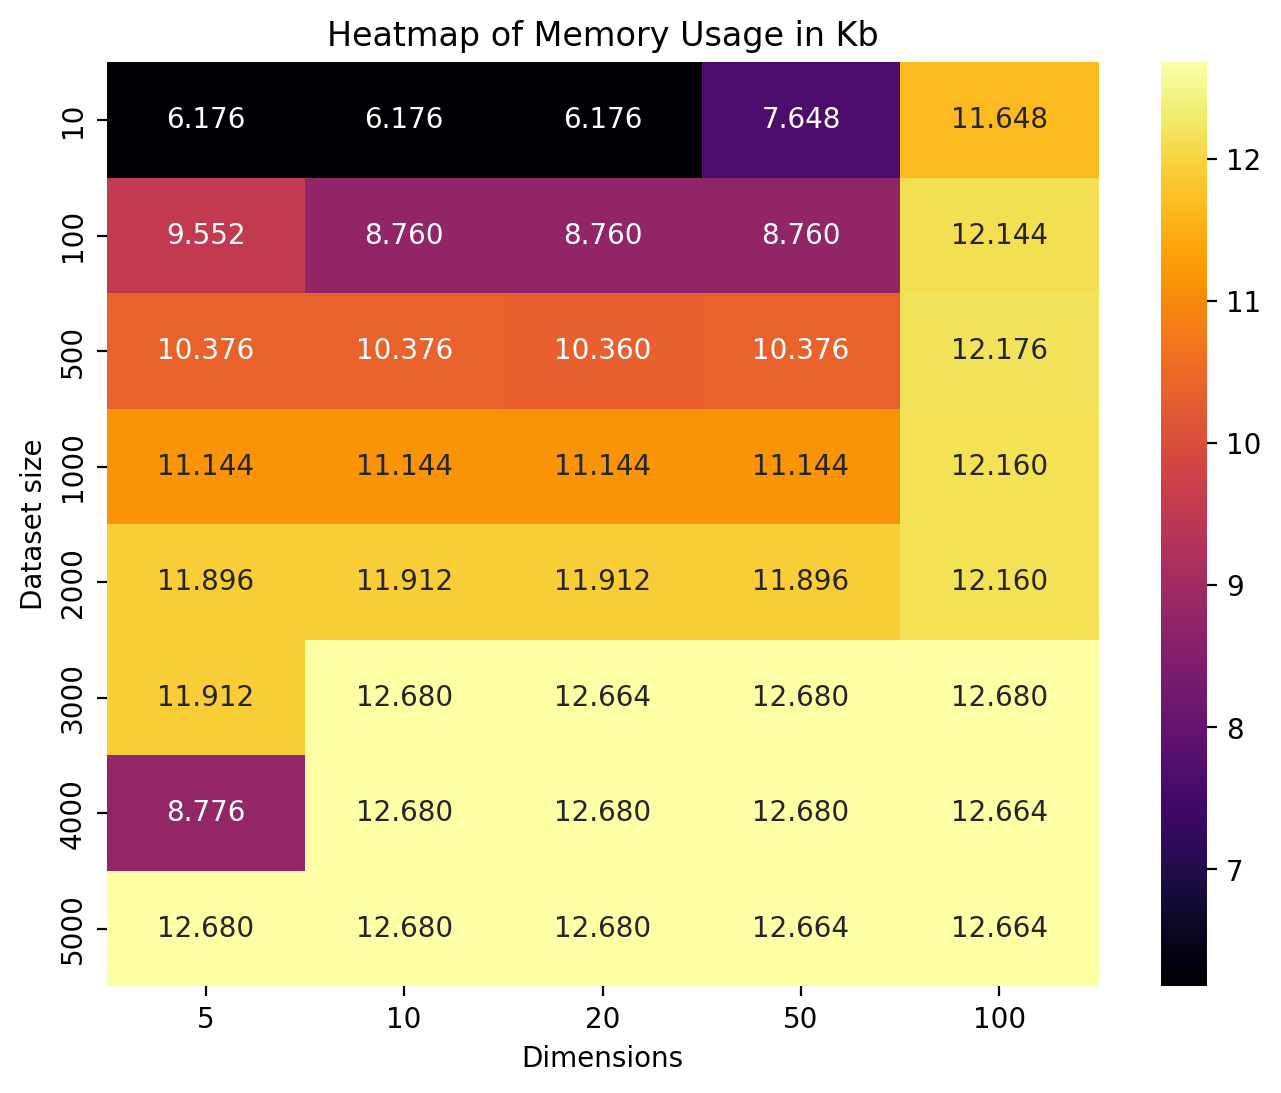

In [129]:
#heatmap of memory usage

plt.figure(figsize=(8, 6))
sns.heatmap(memory_usage_KD_tree_test/1000, annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Memory Usage in Kb')
plt.show()

# LSH 

In [104]:
class LSH:
    def __init__(self, dataset, num_hashes=5):
        self.dataset = dataset
        self.num_hashes = num_hashes
        self.dataset_augmented = np.hstack((self.dataset, np.ones((self.dataset.shape[0], 1))))  # Adding bias term
        self.hashes = self._generate_hashes()  
        self.hash_buckets = self._create_hash_buckets()  # storing hash buckets (Training)

    def _generate_hashes(self):
        return np.random.randn(self.num_hashes, self.dataset.shape[1] + 1)

    def _hash_(self, point):
        point_augmented = np.append(point, 1)  
        return np.sign(np.dot(self.hashes, point_augmented))

    def _create_hash_buckets(self):
        
        hash_buckets = {}
        for index, point in enumerate(self.dataset):
            point_hash = tuple(self._hash_(point))  
            if point_hash not in hash_buckets:
                hash_buckets[point_hash] = []
            hash_buckets[point_hash].append(index)
        return hash_buckets  

    def query(self, query, K):
        
        query_hash = tuple(self._hash_(query))
        
        nearest_neighbors = self.find_k(query, self.hash_buckets.get(query_hash, []), K)

        if len(nearest_neighbors) < K: ## neighbouring buckets
            for i in range(self.num_hashes):
                if len(nearest_neighbors) >= K:
                    break
                modified_query_hash = list(query_hash)
                modified_query_hash[i] = 1 - modified_query_hash[i]  # Flipping the ith hash bit
                modified_query_hash_tuple = tuple(modified_query_hash)
                
                if modified_query_hash_tuple in self.hash_buckets:
                    remaining_neighbors = self.find_k(query, self.hash_buckets[modified_query_hash_tuple], K - len(nearest_neighbors))
                    nearest_neighbors.extend(remaining_neighbors)

        # Sorting again
        nearest_neighbors = sorted(nearest_neighbors, key=lambda x: x[1])[:K]
        nearest_indices = [index for index, _ in nearest_neighbors]
        nearest_points = self.dataset[nearest_indices]
        nearest_distances = [dist for _, dist in nearest_neighbors]

        return nearest_indices, nearest_points, nearest_distances

    def find_k(self, query, bucket_indices, K):
        distances = []
        for index in bucket_indices:
            point = self.dataset[index]
            dist = distance(query, point)
            distances.append((index, dist))
        return sorted(distances, key=lambda x: x[1])[:K]

In [105]:
num_hashes = 15 

lsh = LSH(ds, num_hashes)  ## Training 
nearest_indices, nearest_points, nearest_distances = lsh.query(q, K)  # Testing

print("Query Point:", q)
print(nearest_indices)
print(nearest_points)
print(nearest_distances)

Query Point: [0.07187096 0.34454321 0.05255484 0.58141447 0.85302974 0.54623375
 0.55318067 0.30156586 0.85727964 0.22312574 0.91963132 0.33310057
 0.96409162 0.96363303 0.13554304 0.78346631 0.93907903 0.60390363
 0.93195917 0.55997792 0.54746681 0.79167348 0.87945124 0.26220312
 0.38260695 0.80045984 0.09294899 0.815454   0.86554999 0.58348575
 0.58600342 0.10845021 0.8288864  0.69301133 0.35517534 0.62195083
 0.58116971 0.13830092 0.68883587 0.16736061 0.54476539 0.30666101
 0.56354737 0.62492018 0.49103667 0.81102663 0.33228281 0.89642558
 0.26722873 0.93362054 0.98144031 0.30782705 0.62560573 0.08743154
 0.4168104  0.7383745  0.54984185 0.83777436 0.10512453 0.80223695
 0.1397459  0.2564263  0.98249634 0.89388627 0.28802532 0.04302056
 0.14894867 0.97292619 0.20142927 0.03420045 0.41613311 0.3979794
 0.58493002 0.53681441 0.55310506 0.42440145 0.39446916 0.8260722
 0.03918293 0.13969601 0.87306736 0.64516381 0.4278376  0.74851925
 0.99064731 0.1994517  0.65431299 0.52447319 0.1313

Testing

In [106]:
hashes = 15

In [107]:
#varying the data_set size and the number of dimensions

training_times_LSH = np.zeros((len(dataset_size), len(dimensions)))
testing_times_LSH = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_LSH_train = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_LSH_test = np.zeros((len(dataset_size), len(dimensions)))


for i, N in enumerate(dataset_size):
    for j, D in enumerate(dimensions):
        ds = generate_dataset(N, D)
        q = generate_query(D)
        
        tracemalloc.start()
        
        start_train_time = time.time()
        lsh = LSH(ds, num_hashes=15)
        end_train_time = time.time()
        training_times_LSH[i, j] = end_train_time - start_train_time
        
        current, peak = tracemalloc.get_traced_memory()
        memory_usage_LSH_train[i, j] = peak
        
        tracemalloc.clear_traces()

        tracemalloc.start()
        
        start_test_time = time.time()
        indices, points, distances = lsh.query(q, K)
        end_test_time = time.time()
        testing_times_LSH[i, j] = end_test_time - start_test_time

        current, peak = tracemalloc.get_traced_memory()
        memory_usage_LSH_test[i, j] = peak

        tracemalloc.clear_traces()

tracemalloc.stop()


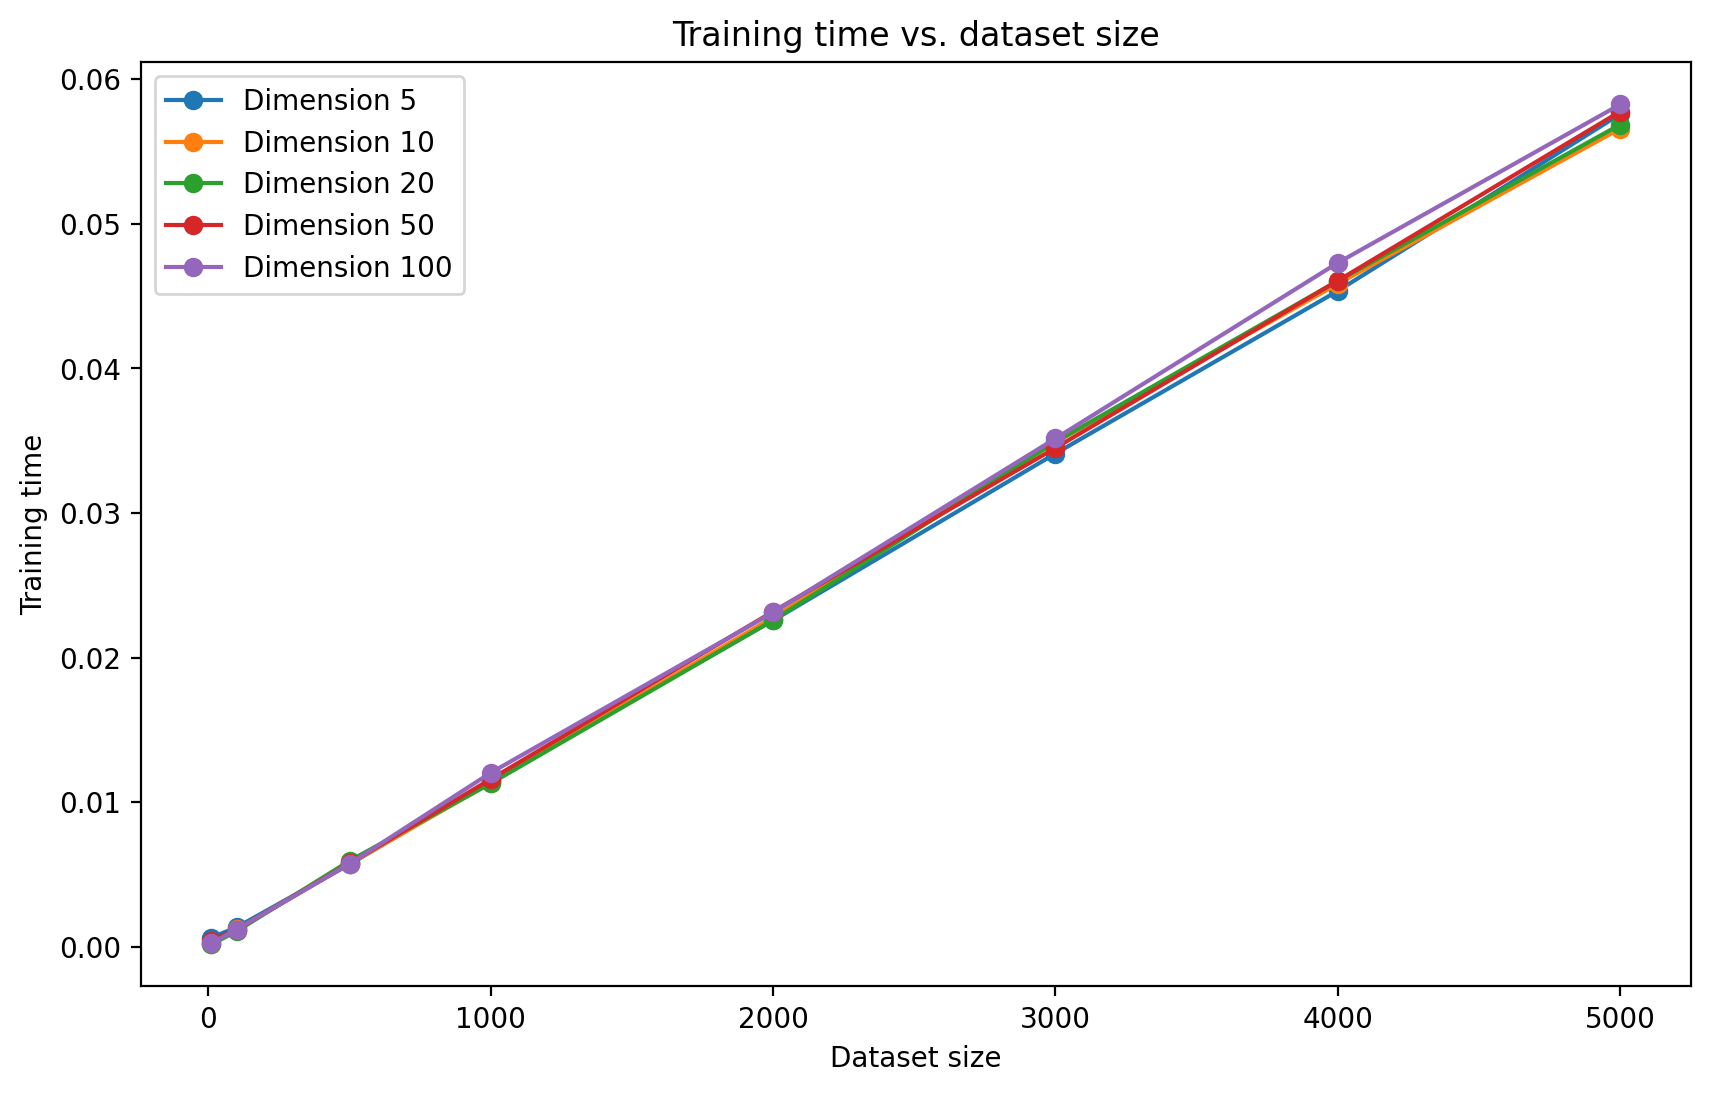

In [108]:
#plotting various figures to understand the variation

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, training_times_LSH[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Training time')
plt.title('Training time vs. dataset size')
plt.legend()


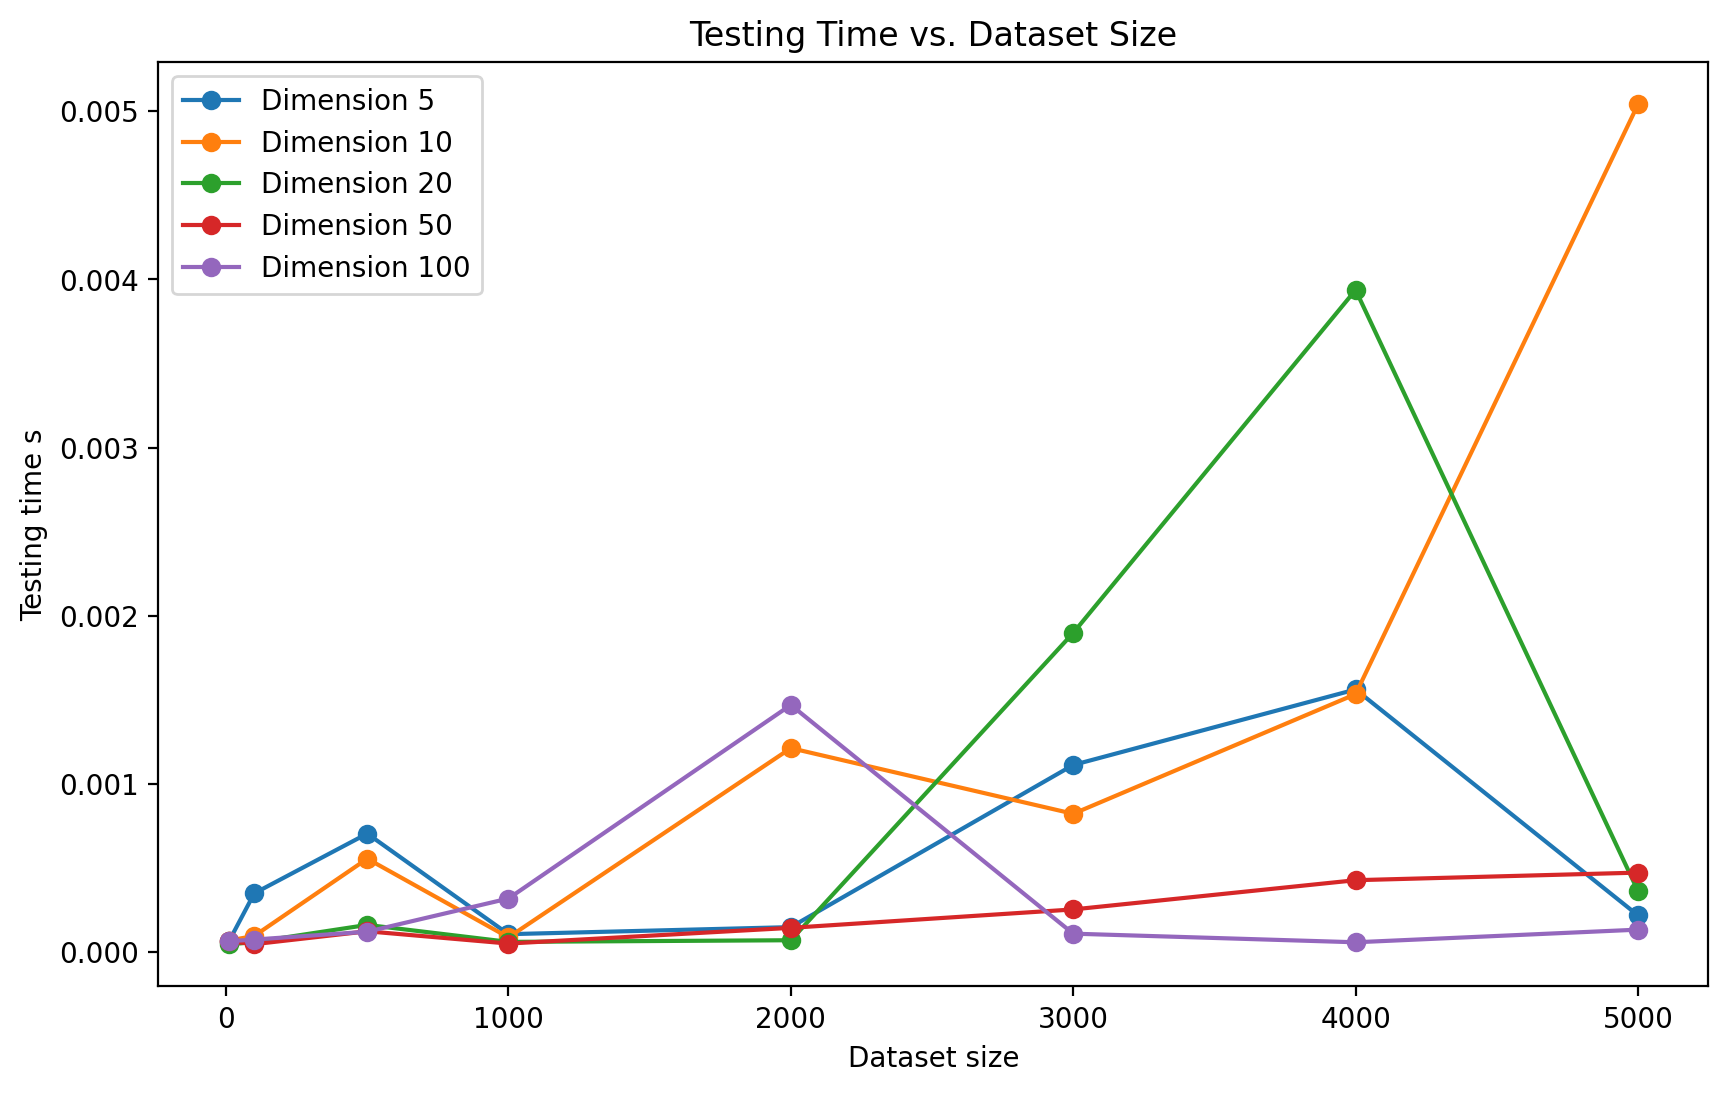

In [109]:
#testing time

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, testing_times_LSH[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Testing time s')
plt.title('Testing Time vs. Dataset Size')
plt.legend()


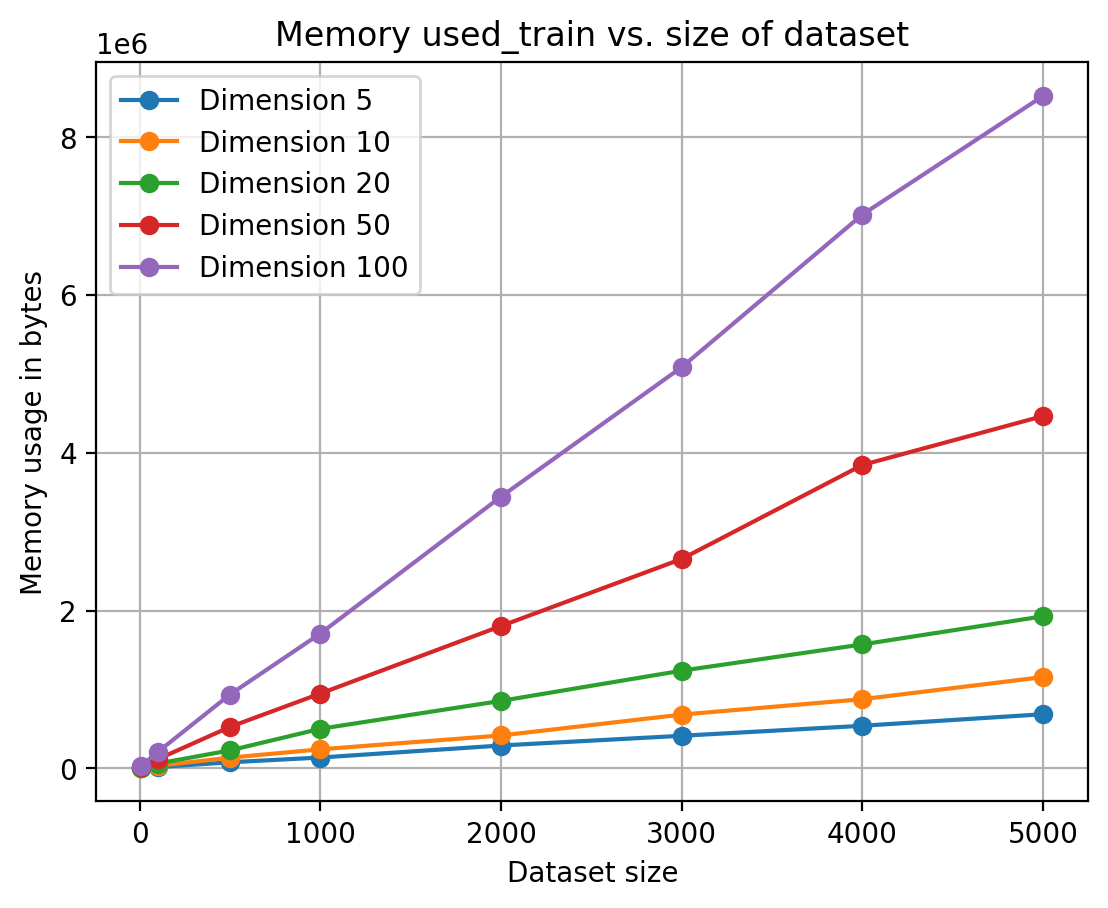

In [110]:
#memory used for training
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_LSH_train[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage in bytes')
plt.title('Memory used_train vs. size of dataset')
plt.legend()
plt.grid(True)
plt.show()


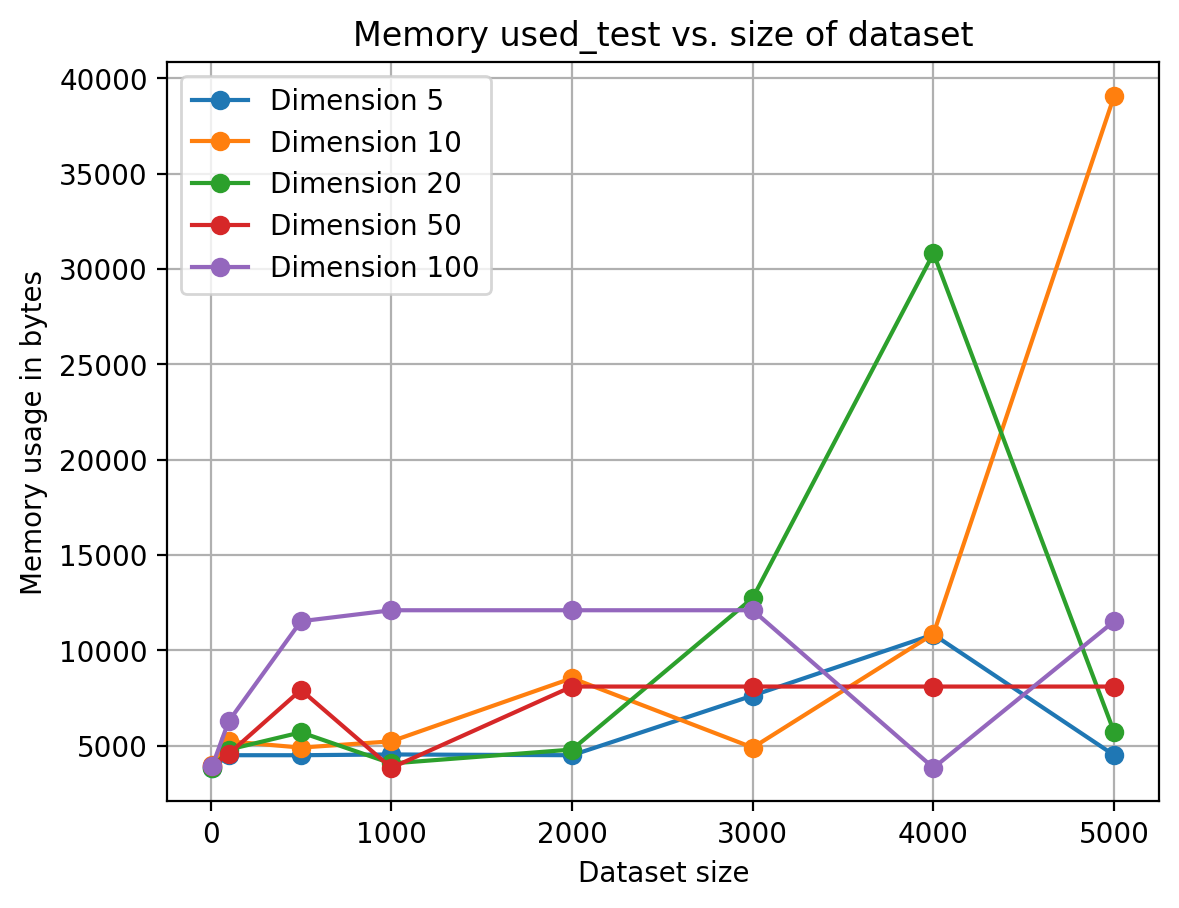

In [111]:
#memory used for testing with varing dimensions and data set size

for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_LSH_test[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory usage in bytes')
plt.title('Memory used_test vs. size of dataset')
plt.legend()
plt.grid(True)
plt.show()

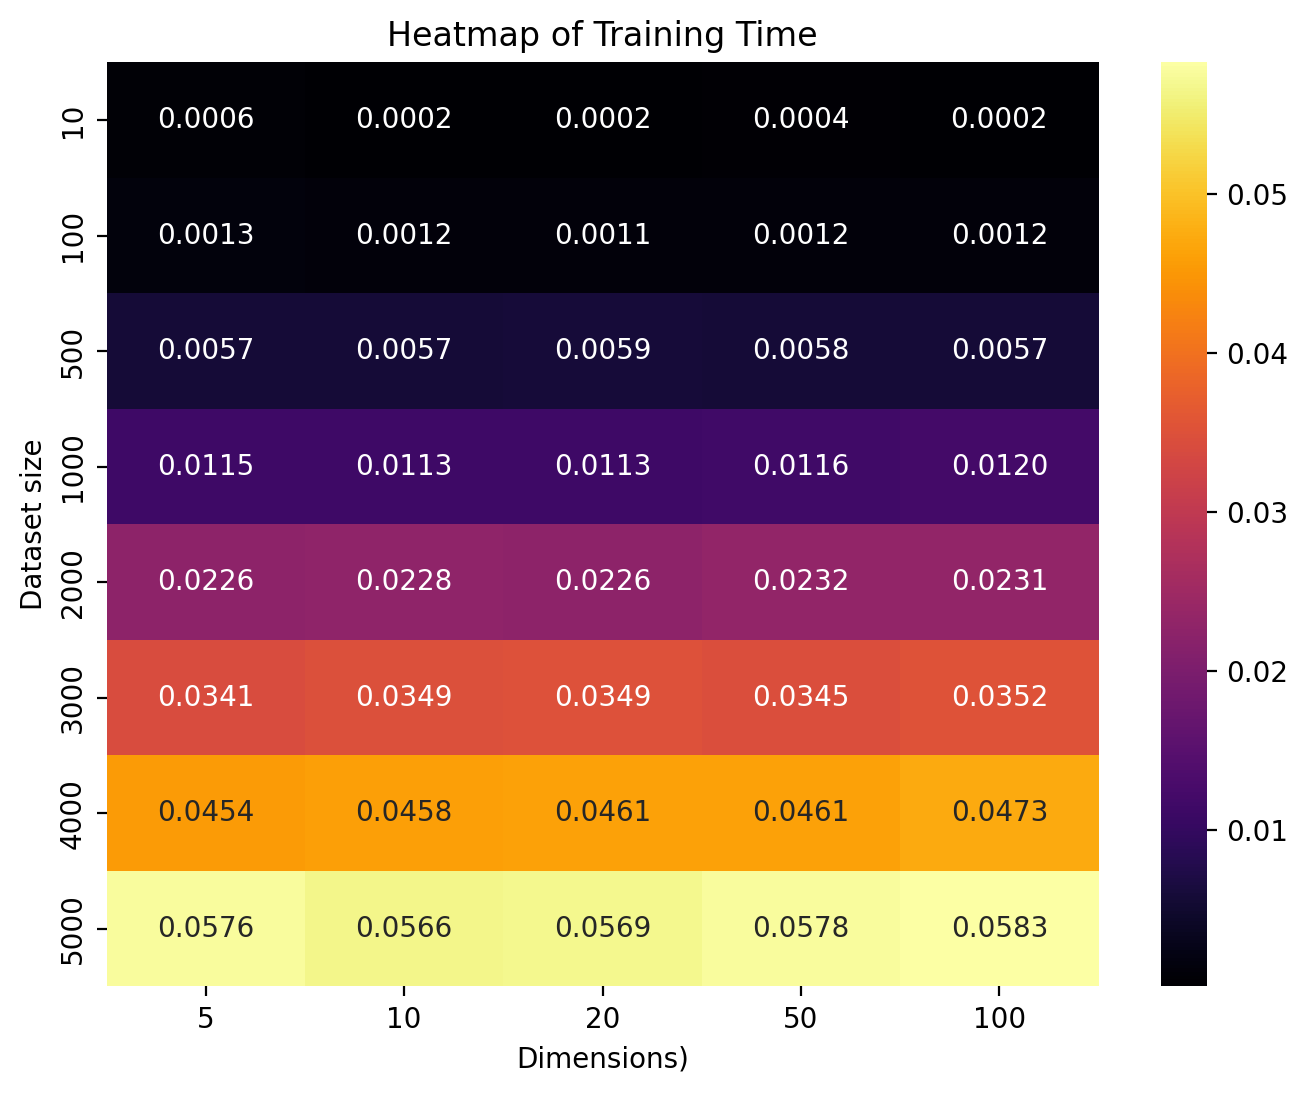

In [112]:
#plotting heatmaps for trainign time vs varying dimensions and dataset size

#plotting heatmap for visualization in 2d space
plt.figure(figsize=(8, 6))
sns.heatmap(training_times_LSH, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions)')
plt.ylabel('Dataset size')
plt.title('Heatmap of Training Time')
plt.show()

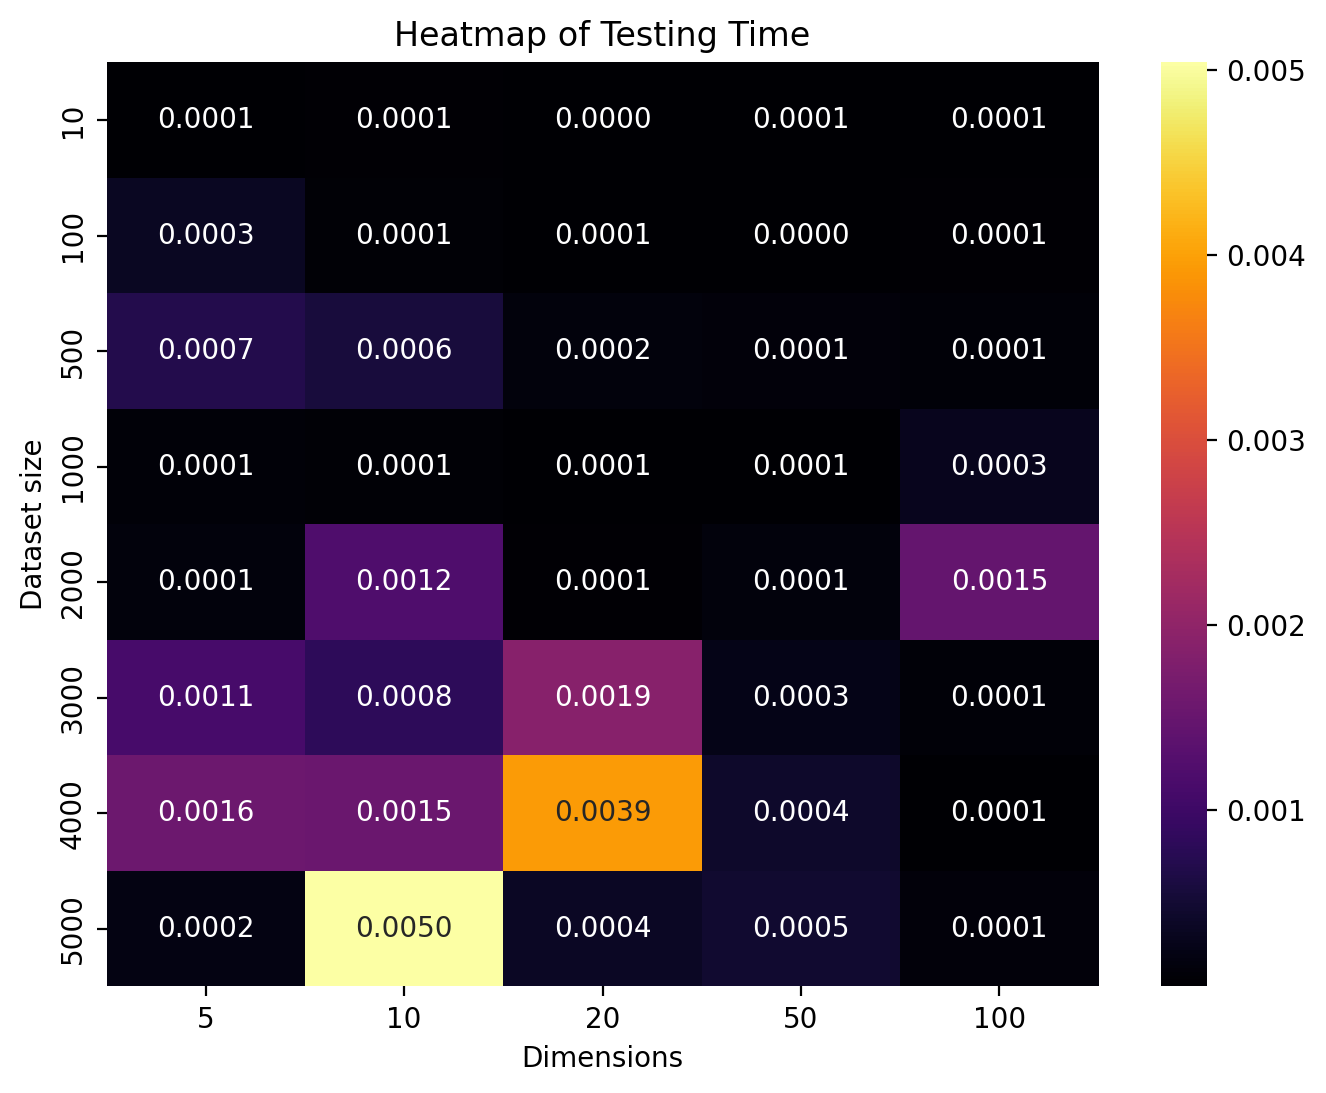

In [113]:
#heatmap for testing time for varying dataset size and the number of dimensions

plt.figure(figsize=(8, 6))
sns.heatmap(testing_times_LSH, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Testing Time')
plt.show()

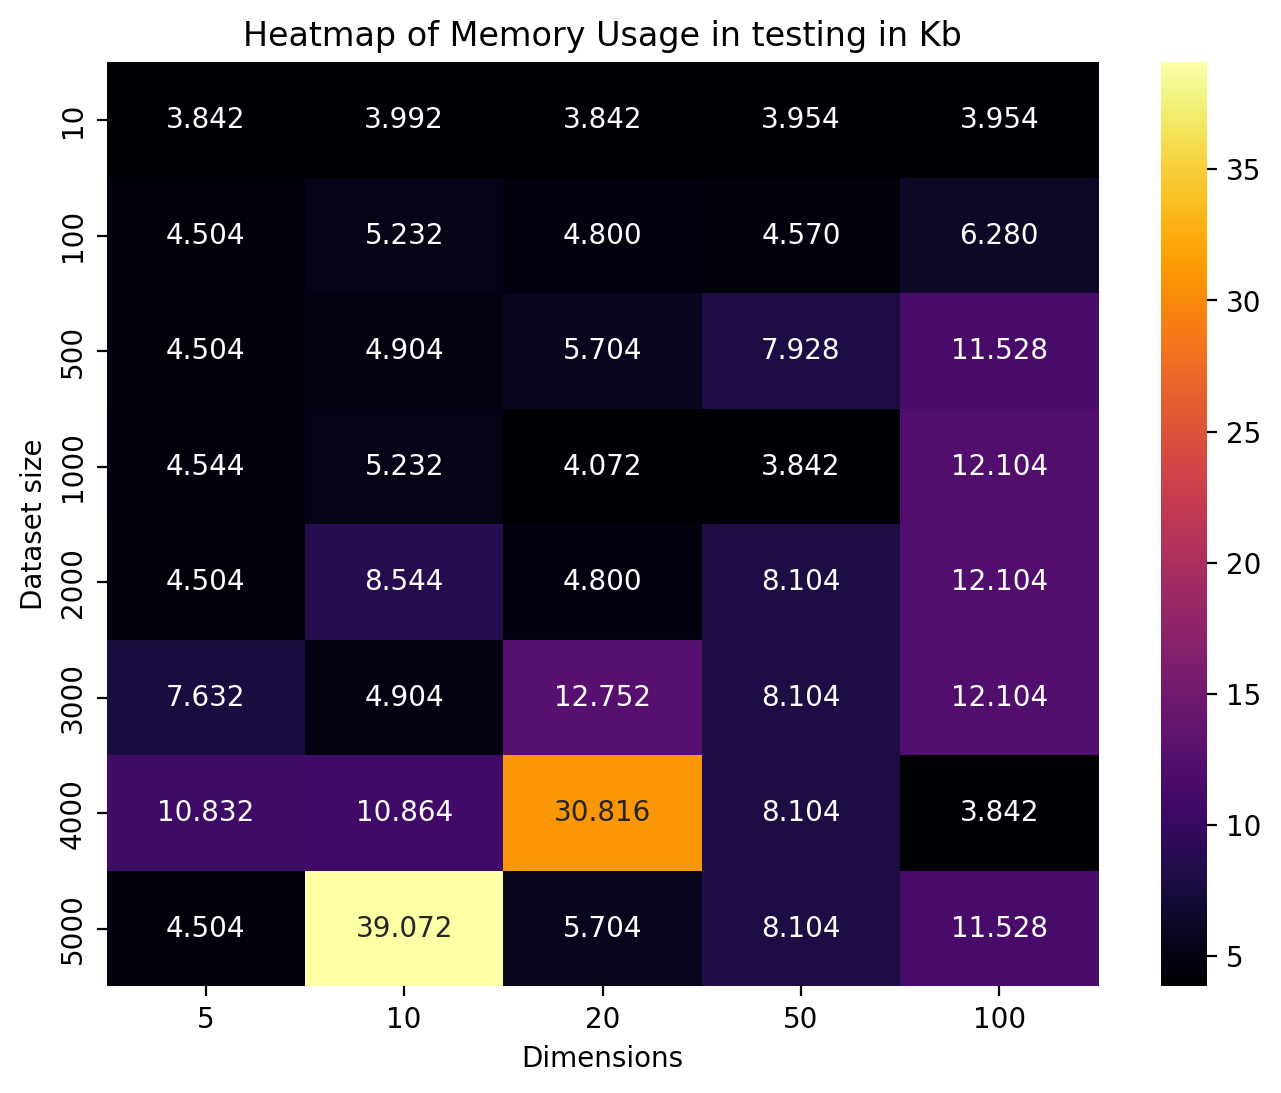

In [114]:
#heatmap of memory required for testing

plt.figure(figsize=(8, 6))
sns.heatmap(memory_usage_LSH_test/1000, annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Memory Usage in testing in Kb')
plt.show()

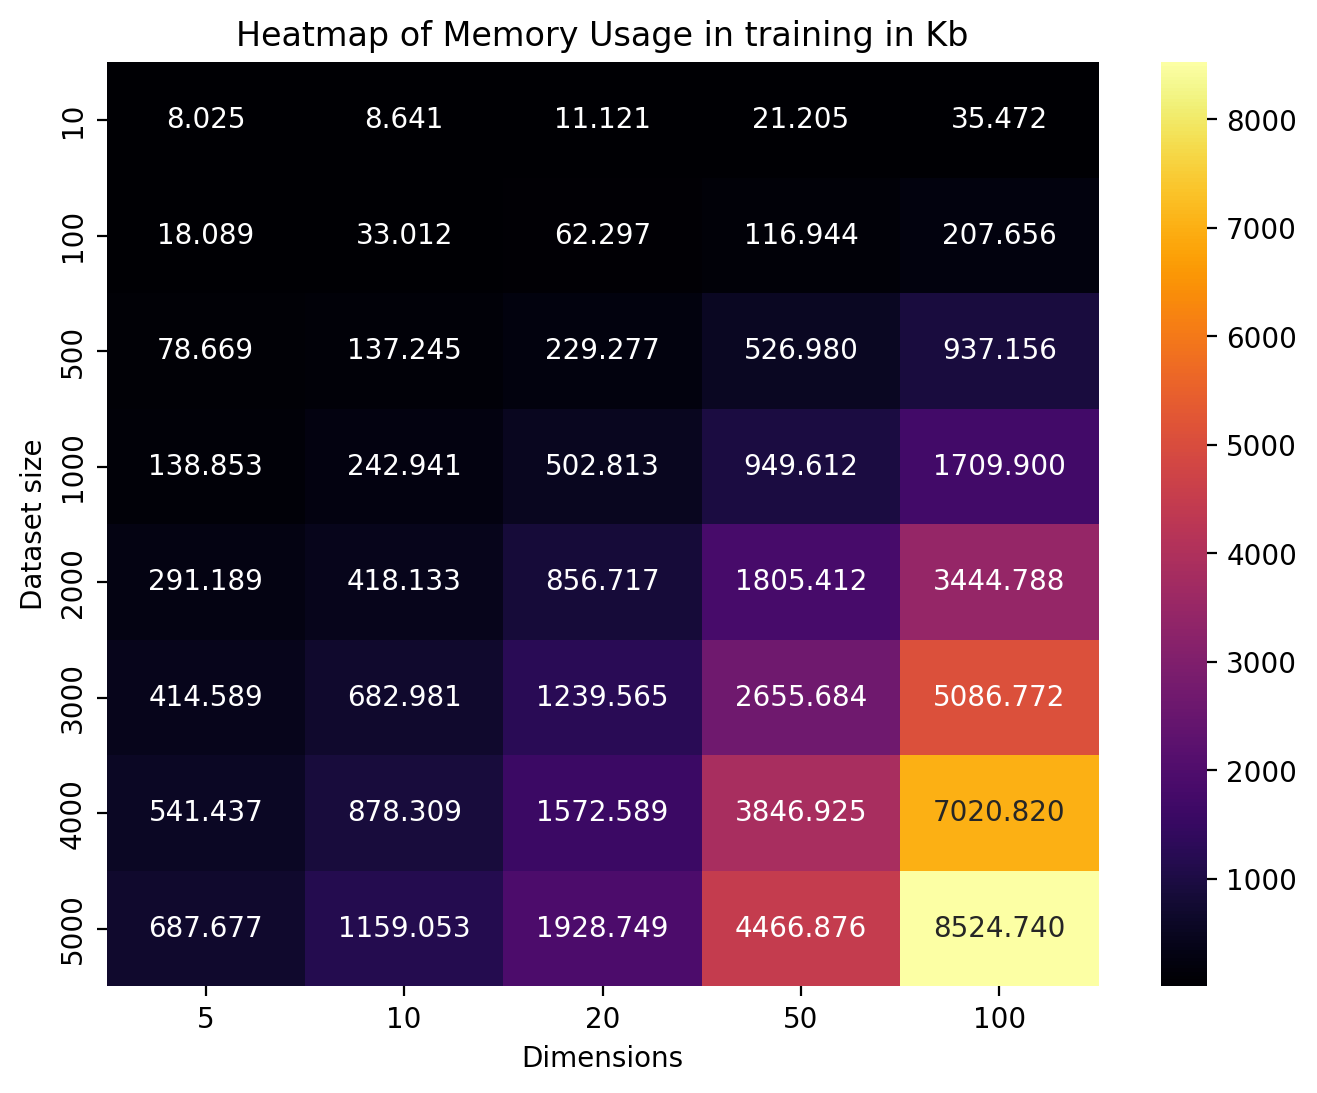

In [115]:
#heatmap of memory required for testing

plt.figure(figsize=(8, 6))
sns.heatmap(memory_usage_LSH_train/1000, annot=True, fmt=".3f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Memory Usage in training in Kb')
plt.show()

## Naive KNN testing

In [116]:
# there is no training, only testing is the phase which consumes a lot of time and requires high amt of memory

testing_times_naive = np.zeros((len(dataset_size), len(dimensions)))
memory_usage_naive = np.zeros((len(dataset_size), len(dimensions)))

for i, N in enumerate(dataset_size):
    for j, D in enumerate(dimensions):
        ds = generate_dataset(N, D)
        q = generate_query(D)
        
        tracemalloc.start()
        
        # Testing time and memory usage for Naive KNN
        start_test_time_naive = time.time()
        indices_naive, points_naive, distances_naive = naive_knn(q, ds, K)
        end_test_time_naive = time.time()
        testing_times_naive[i, j] = end_test_time_naive - start_test_time_naive
        
        current, peak = tracemalloc.get_traced_memory()
        memory_usage_naive[i, j] = peak
        
        tracemalloc.clear_traces()

tracemalloc.stop()

Plots


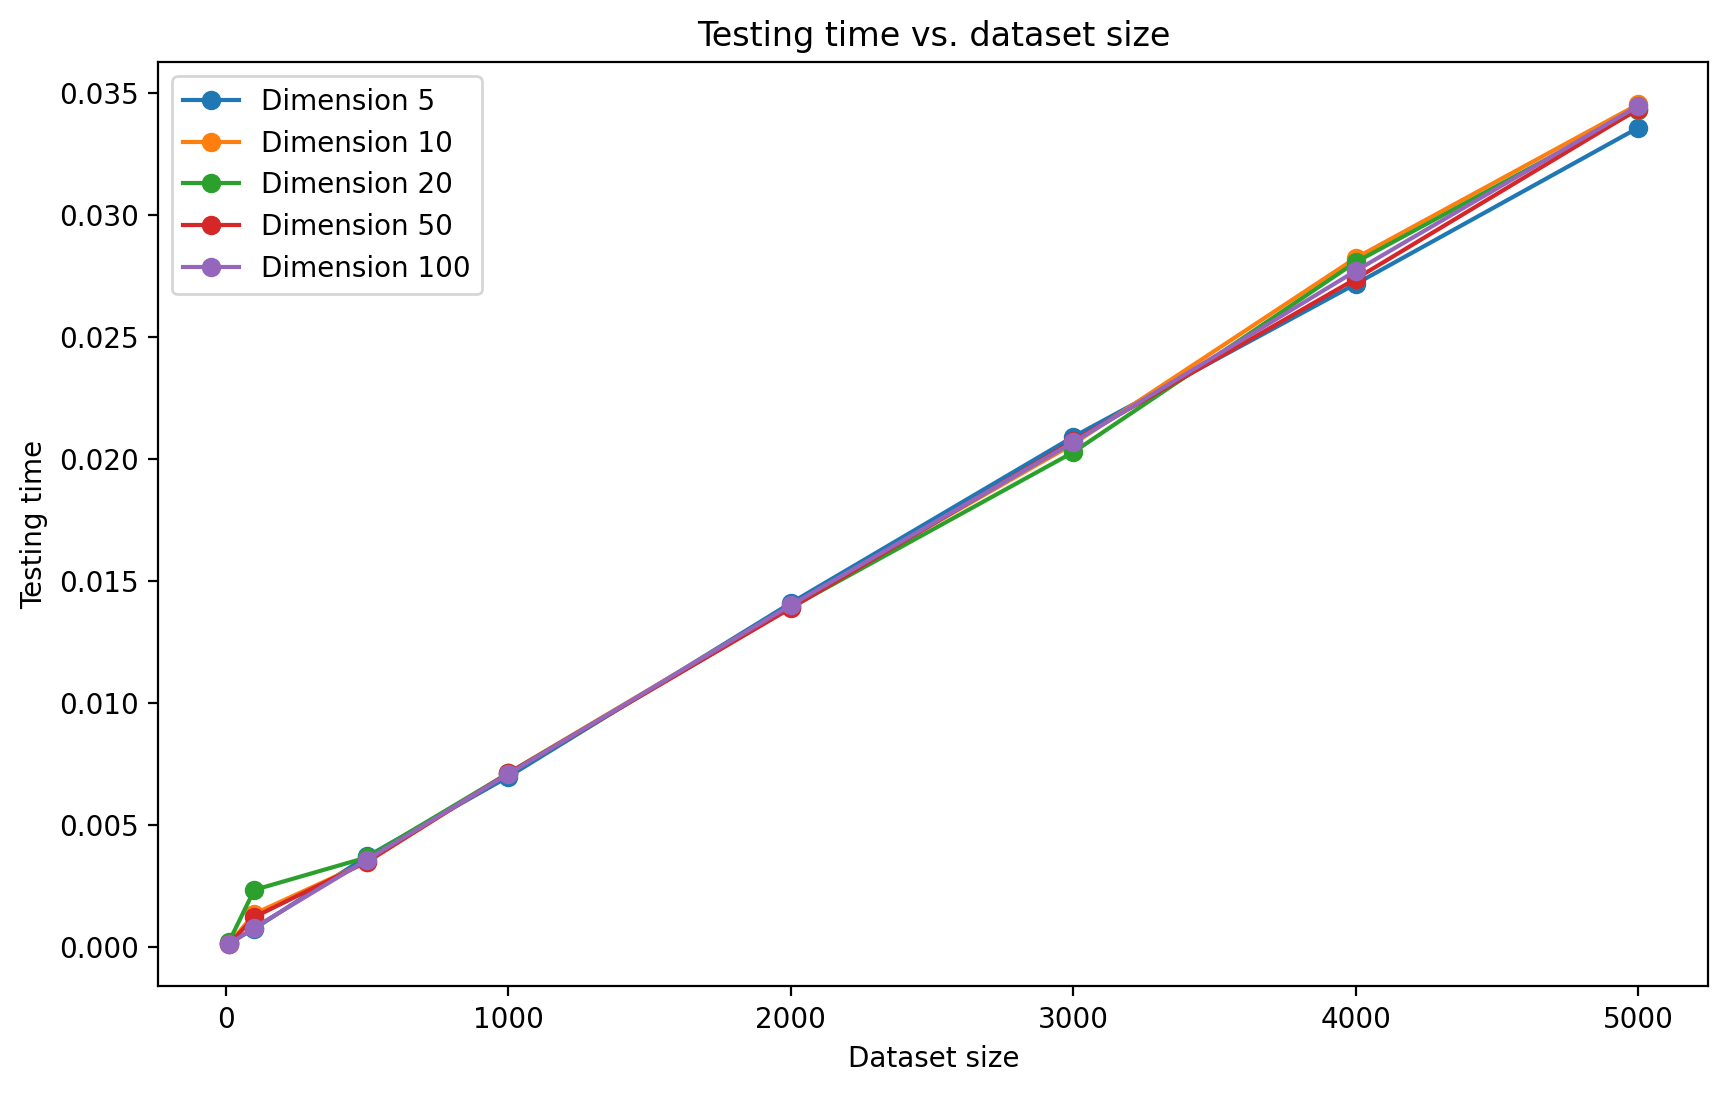

In [117]:
#plotting various figures to understand the variation

plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, testing_times_naive[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Testing time')
plt.title('Testing time vs. dataset size')
plt.legend()

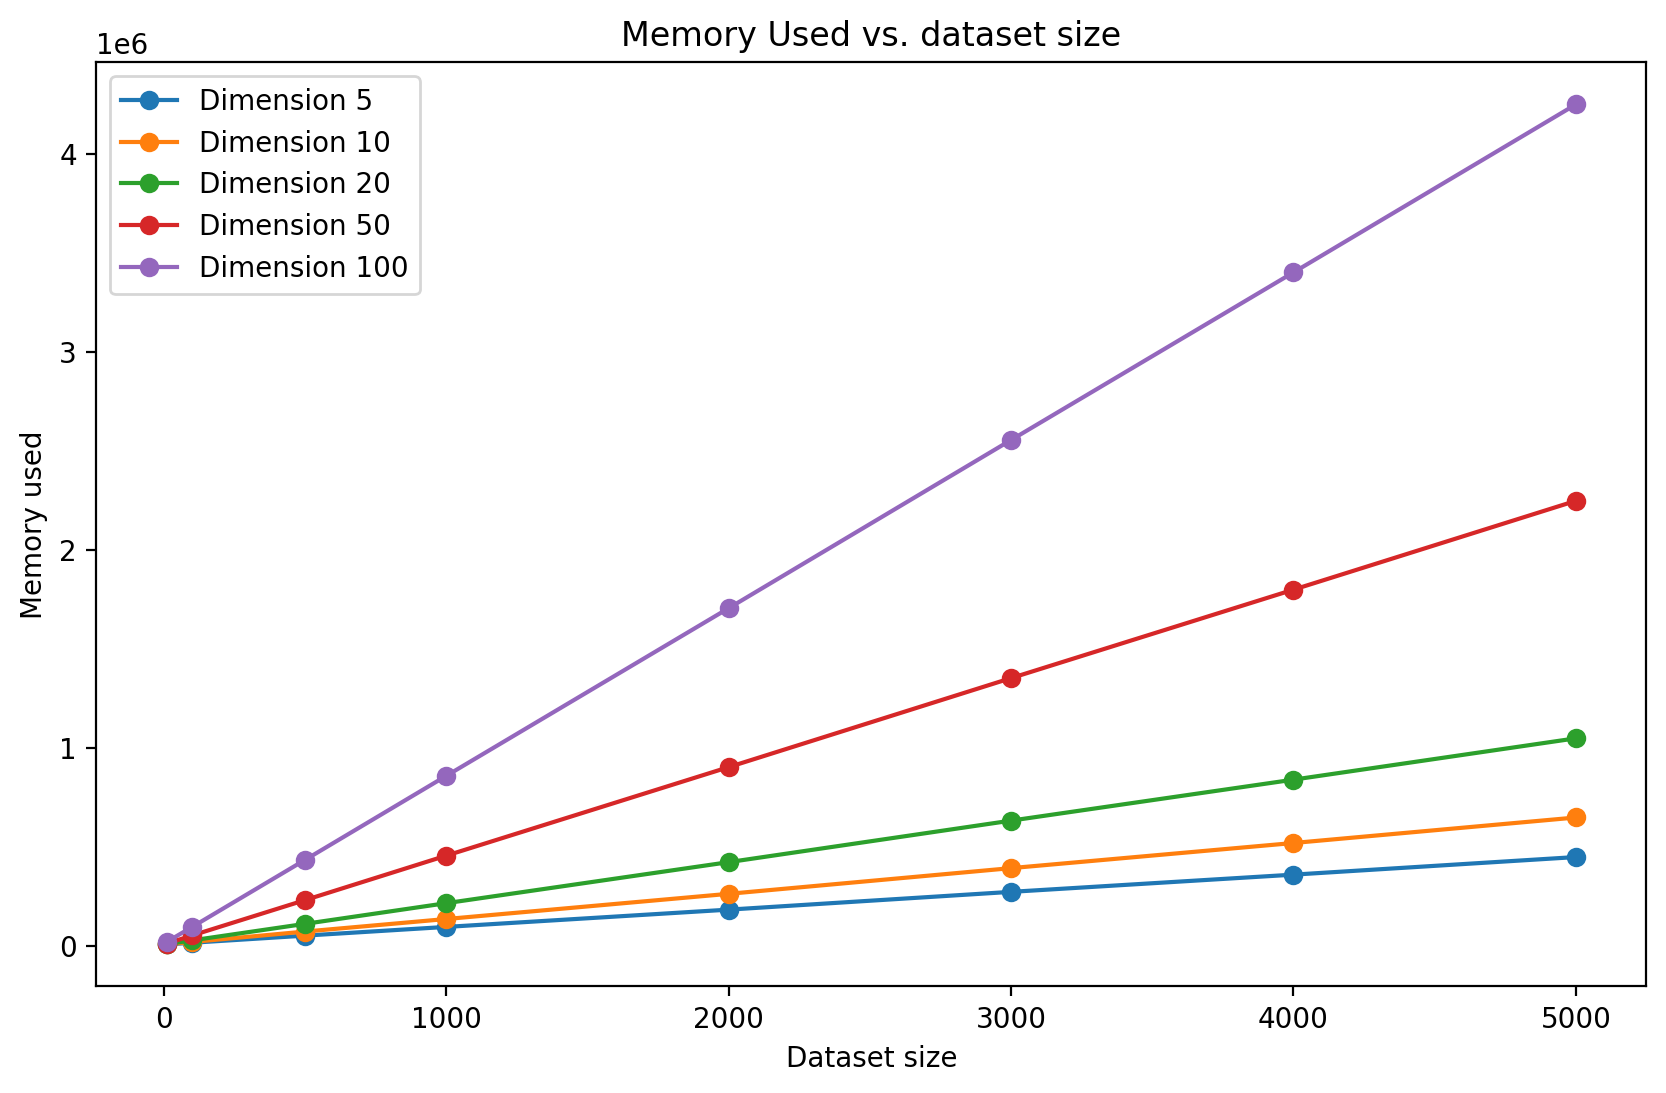

In [118]:
plt.figure(figsize=(10, 6))
for j, D in enumerate(dimensions):
    plt.plot(dataset_size, memory_usage_naive[:, j], marker='o', label=f'Dimension {D}')
plt.xlabel('Dataset size')
plt.ylabel('Memory used')
plt.title('Memory Used vs. dataset size')
plt.legend()

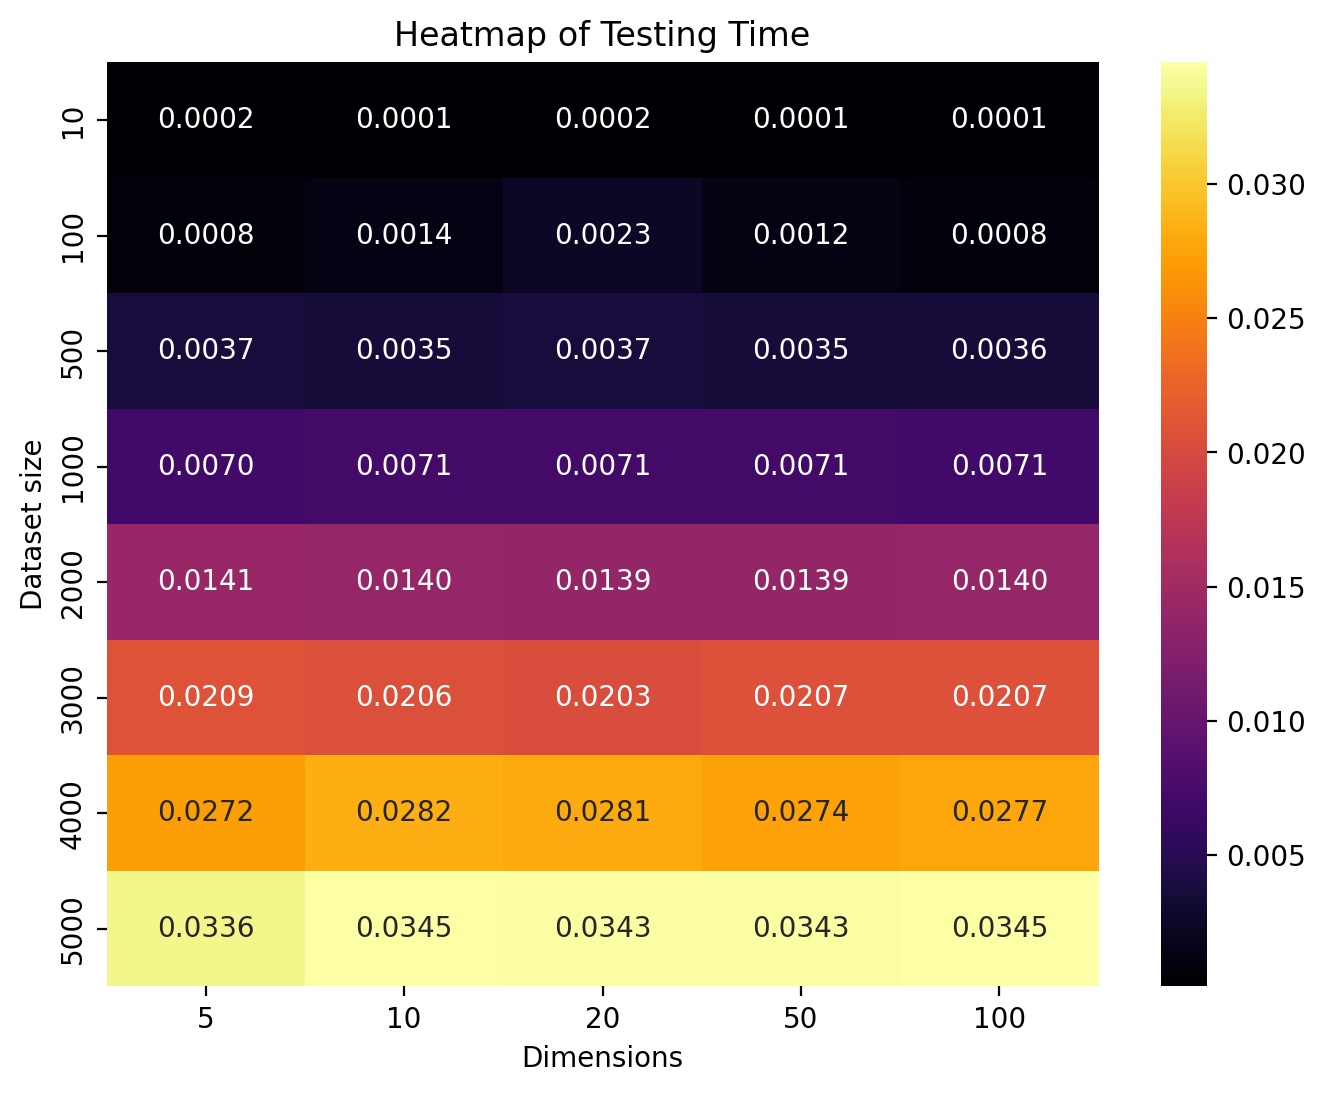

In [119]:
#plotting the heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(testing_times_naive, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions')
plt.ylabel('Dataset size')
plt.title('Heatmap of Testing Time')
plt.show()

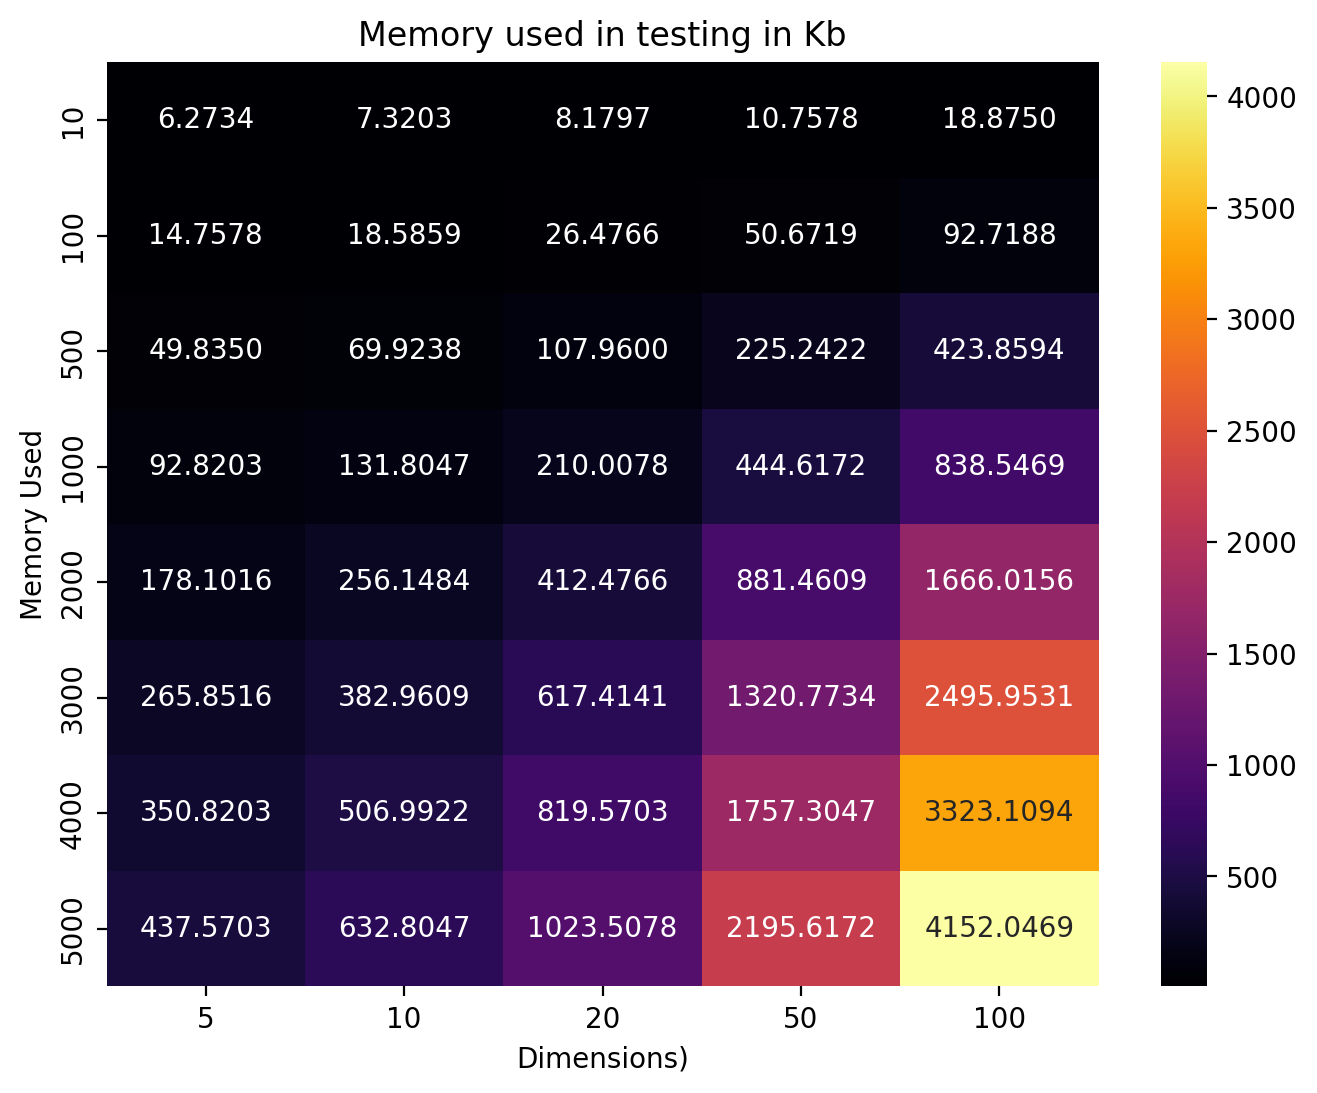

In [120]:
plt.figure(figsize=(8, 6))
memory_usage_naive = memory_usage_naive / 1024  # Converting bytes to kilobytes
sns.heatmap(memory_usage_naive, annot=True, fmt=".4f", xticklabels=dimensions, yticklabels=dataset_size, cmap="inferno")
plt.xlabel('Dimensions)')
plt.ylabel('Memory Used')
plt.title('Memory used in testing in Kb')
plt.show()